In [8]:
import flowkit as fk
import os
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import phenograph 
import pacmap
import matplotlib.pyplot as plt


In [9]:
fcs_files = glob.glob("data/flow_cytometry/microplastics/*.fcs")


In [10]:
## Load FCS files and concatenate data
total_df = pd.DataFrame()
dfs = []
for file in fcs_files:
    sample = fk.Sample(file).as_dataframe(source="raw")
    # add a column with the filename without path and extension
    sample['sample_id'] = os.path.basename(file).replace('.fcs', '')
    total_df = pd.concat([total_df, sample], ignore_index=True)

In [11]:
# Mantieni solo il primo livello del MultiIndex come nomi delle colonne
total_df.columns = total_df.columns.get_level_values(0)
print(list(total_df.columns))

['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'BB515-A', 'BB515-H', 'BB515-W', 'RB613-A', 'RB613-H', 'RB613-W', 'BB660-A', 'BB660-H', 'BB660-W', 'BB700-A', 'BB700-H', 'BB700-W', 'RB744-A', 'RB744-H', 'RB744-W', 'RB780-A', 'RB780-H', 'RB780-W', 'Alexa Fluor 647-A', 'Alexa Fluor 647-H', 'Alexa Fluor 647-W', 'APC-R700-A', 'APC-R700-H', 'APC-R700-W', 'APC-Cy7-A', 'APC-Cy7-H', 'APC-Cy7-W', 'BV421-A', 'BV421-H', 'BV421-W', 'BV510-A', 'BV510-H', 'BV510-W', 'BV570-A', 'BV570-H', 'BV570-W', 'BV605-A', 'BV605-H', 'BV605-W', 'BV650-A', 'BV650-H', 'BV650-W', 'BV711-A', 'BV711-H', 'BV711-W', 'BV750-A', 'BV750-H', 'BV750-W', 'BV786-A', 'BV786-H', 'BV786-W', 'BUV395-A', 'BUV395-H', 'BUV395-W', 'DAPI-A', 'DAPI-H', 'DAPI-W', 'BUV496-A', 'BUV496-H', 'BUV496-W', 'BUV563-A', 'BUV563-H', 'BUV563-W', 'BUV615-A', 'BUV615-H', 'BUV615-W', 'BUV661-A', 'BUV661-H', 'BUV661-W', 'BUV737-A', 'BUV737-H', 'BUV737-W', 'BUV805-A', 'BUV805-H', 'BUV805-W', 'PE-A', 'PE-H', 'PE-W', 'PE-CF594-A', 'PE-CF594-H', 'PE-C

In [12]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy as sch

# ensure columns are simple strings
if isinstance(total_df.columns, pd.MultiIndex):
    total_df.columns = total_df.columns.get_level_values(0)

# markers: end with '-A', exclude FSC/SSC
markers = [c for c in total_df.columns if c != "sample_id"]
if len(markers) == 0:
    raise RuntimeError("No marker columns found (columns ending with '-A').")

filtered_df = total_df[markers].dropna(how='all')
if filtered_df.shape[0] == 0:
    raise RuntimeError("Filtered dataframe is empty after dropping rows with all-NaN for markers.")

# pool sample for embedding scaler and MinMax normalization

# scaler for embedding (StandardScaler)
scaler_for_embedding = StandardScaler().fit(filtered_df.values)

# MinMax scaler for heatmap visualization (fit on pooled sample)
minmax_scaler = MinMaxScaler().fit(filtered_df.values)

# fixed vmin/vmax for MinMax (always 0 to 1)
vmin, vmax = 0.0, 1.0
print(f"using heatmap vmin={vmin:.3f}, vmax={vmax:.3f} (MinMax normalized)")

out_dir = "./figures/heatmap_minmax"
os.makedirs(out_dir, exist_ok=True)

# params
max_events_per_file = 50000
n_clusters = 8
random_state = 42

# sample ordering by per-sample raw mean signatures
sample_ids = list(total_df['sample_id'].unique())
sigs = []; valid_samples = []
for sid in sample_ids:
    samp_df = total_df.loc[total_df['sample_id'] == sid, markers].dropna()
    if samp_df.shape[0] < 50:
        print(f"skip {sid}: too few events ({samp_df.shape[0]})")
        continue
    sigs.append(samp_df.mean(axis=0).values)
    valid_samples.append(sid)

if len(sigs) > 1:
    sig_array = np.vstack(sigs)
    try:
        linkage = sch.linkage(1 - np.corrcoef(sig_array), method='average')
        order_idx = sch.leaves_list(linkage)
        ordered_samples = [valid_samples[i] for i in order_idx]
    except Exception as e:
        print("clustering signatures failed, using original order:", e)
        ordered_samples = valid_samples
else:
    ordered_samples = valid_samples

print("plot order:", ordered_samples)

# loop samples -> embed, cluster, heatmap (MinMax normalized means, same color scale)
for sample_id in ordered_samples:
    samp_df = total_df.loc[total_df['sample_id'] == sample_id, markers].dropna()
    if samp_df.shape[0] < 50:
        print(f"skip {sample_id}: too few events ({samp_df.shape[0]})")
        continue

    sample_n = min(max_events_per_file, len(samp_df))
    try:
        samp_sub = samp_df.sample(n=sample_n, random_state=random_state).dropna()
    except Exception:
        print(f"skip {sample_id}: sampling failed")
        continue
    if samp_sub.shape[0] == 0:
        print(f"skip {sample_id}: no usable rows after dropna")
        continue

    X = scaler_for_embedding.transform(samp_sub.values)
    try:
        reducer = pacmap.PaCMAP(n_components=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0, random_state=random_state)
        embedding = reducer.fit_transform(X)
    except Exception as e:
        print(f"embedding failed for {sample_id}: {e}")
        continue

    k = min(n_clusters, max(2, int(np.sqrt(sample_n/50)) + 2))
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=random_state)
    clusters = kmeans.fit_predict(X)

    # cluster-by-marker mean matrix (raw means first, then MinMax normalize)
    cluster_means = pd.DataFrame(samp_sub.values, columns=markers).groupby(clusters).mean()
    if cluster_means.shape[0] == 0:
        print(f"skip {sample_id}: no clusters produced")
        continue
    
    # apply MinMax normalization to cluster means using pooled scaler
    cluster_means_minmax = pd.DataFrame(
        minmax_scaler.transform(cluster_means.values),
        columns=cluster_means.columns,
        index=cluster_means.index
    )

    # order clusters by overall mean intensity for consistent row ordering
    cluster_order = cluster_means_minmax.mean(axis=1).sort_values(ascending=False).index
    cluster_means_ordered = cluster_means_minmax.loc[cluster_order]

    # plotting: keep only heatmap with MinMax normalized values
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    sns.heatmap(cluster_means_ordered, ax=ax, cmap='vlag', vmin=vmin, vmax=vmax,
                cbar_kws={'label': 'mean expression (MinMax norm)'}, linewidths=0.5, center=0.5)
    ax.set_title(f"Cluster x Marker (MinMax norm, pooled scale) - {sample_id}")
    ax.set_xlabel("Markers")
    ax.set_ylabel("Cluster")
    plt.tight_layout()
    out_path = os.path.join(out_dir, f"heatmap_minmax_{sample_id}.png")
    fig.savefig(out_path, dpi=150)
    plt.close(fig)
    print("wrote", out_path)

print("Analysis completed! Check ./figures/heatmap_minmax/ for output files.")

using heatmap vmin=0.000, vmax=1.000 (MinMax normalized)


/tmp/ipykernel_14573/3264066219.py:57: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(1 - np.corrcoef(sig_array), method='average')


plot order: ['02092024_Sangue_topi_Sangue_triton_topo_2', '02092024_Sangue_topi_Sangue_triton_topo_1', '02092024_Sangue_topi_Sangue_triton_topo_3', '02092024_Sangue_topi_Sangue_triton_topo_4', '02092024_Sangue_topi_Sangue_topo_3_Triton_800nm_', '02092024_Sangue_topi_Sangue_topo_4_Triton_800nm', '02092024_Sangue_topi_Sangue_topo_2_Triton_800nm', '02092024_Sangue_topi_Sangue_topo_1_Triton_800nm', '02092024_Sangue_topi_Sangue_topo_2', '02092024_Sangue_topi_Sangue_topo_2_800nm', '02092024_Sangue_topi_Sangue_topo_4_800nm', '02092024_Sangue_topi_Sangue_topo_1', '02092024_Sangue_topi_Sangue_topo_4', '02092024_Sangue_topi_Sangue_topo_3_800nm', '02092024_Sangue_topi_Sangue_topo_3', '02092024_Sangue_topi_Sangue_topo_1_800nm']


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_triton_topo_2.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_triton_topo_1.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_triton_topo_3.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_triton_topo_4.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_3_Triton_800nm_.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_4_Triton_800nm.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_2_Triton_800nm.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_1_Triton_800nm.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_2.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_2_800nm.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_4_800nm.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_1.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_4.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_3_800nm.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_3.png


wrote ./figures/heatmap_minmax/heatmap_minmax_02092024_Sangue_topi_Sangue_topo_1_800nm.png
Analysis completed! Check ./figures/heatmap_minmax/ for output files.



Found 8 triton samples to exclude: ['02092024_Sangue_topi_Sangue_topo_2_Triton_800nm', '02092024_Sangue_topi_Sangue_triton_topo_3', '02092024_Sangue_topi_Sangue_topo_3_Triton_800nm_', '02092024_Sangue_topi_Sangue_triton_topo_4', '02092024_Sangue_topi_Sangue_triton_topo_2', '02092024_Sangue_topi_Sangue_topo_1_Triton_800nm', '02092024_Sangue_topi_Sangue_triton_topo_1', '02092024_Sangue_topi_Sangue_topo_4_Triton_800nm']
Remaining 8 samples after filtering out triton samples

Processing 8 samples (excluding triton):
  ✓ 02092024_Sangue_topi_Sangue_topo_3: 100000 events
  ✓ 02092024_Sangue_topi_Sangue_topo_4_800nm: 100000 events
  ✓ 02092024_Sangue_topi_Sangue_topo_2: 100000 events
  ✓ 02092024_Sangue_topi_Sangue_topo_1_800nm: 100000 events
  ✓ 02092024_Sangue_topi_Sangue_topo_1: 100000 events
  ✓ 02092024_Sangue_topi_Sangue_topo_2_800nm: 100000 events
  ✓ 02092024_Sangue_topi_Sangue_topo_3_800nm: 100000 events
  ✓ 02092024_Sangue_topi_Sangue_topo_4: 100000 events

RAW sample means matrix 

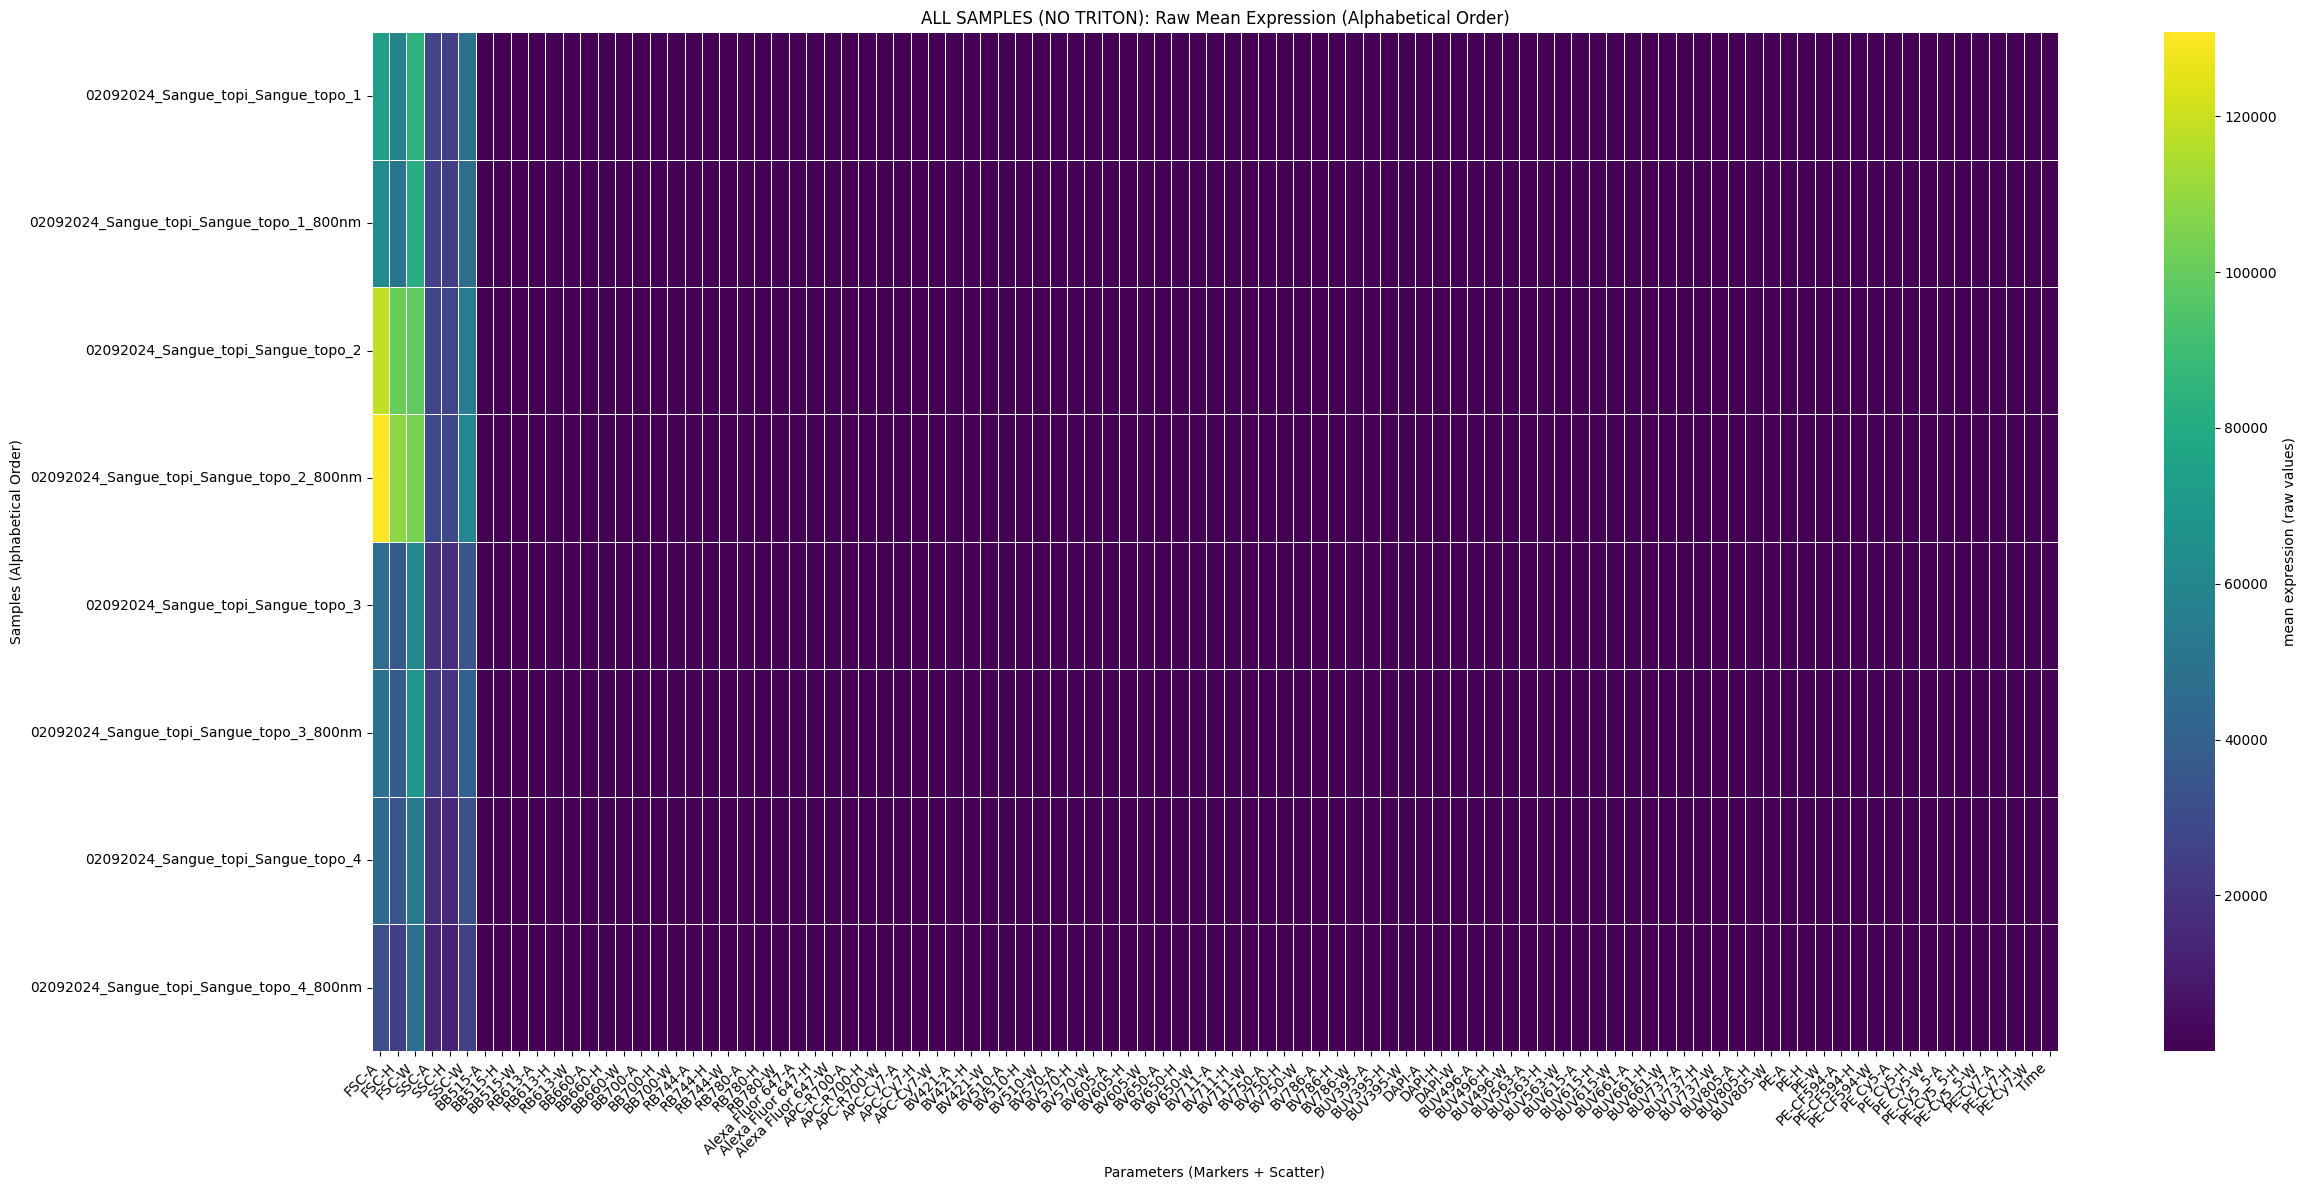

✓ Saved: ./figures/all_samples_analysis_no_triton/all_samples_raw_values_no_triton.png


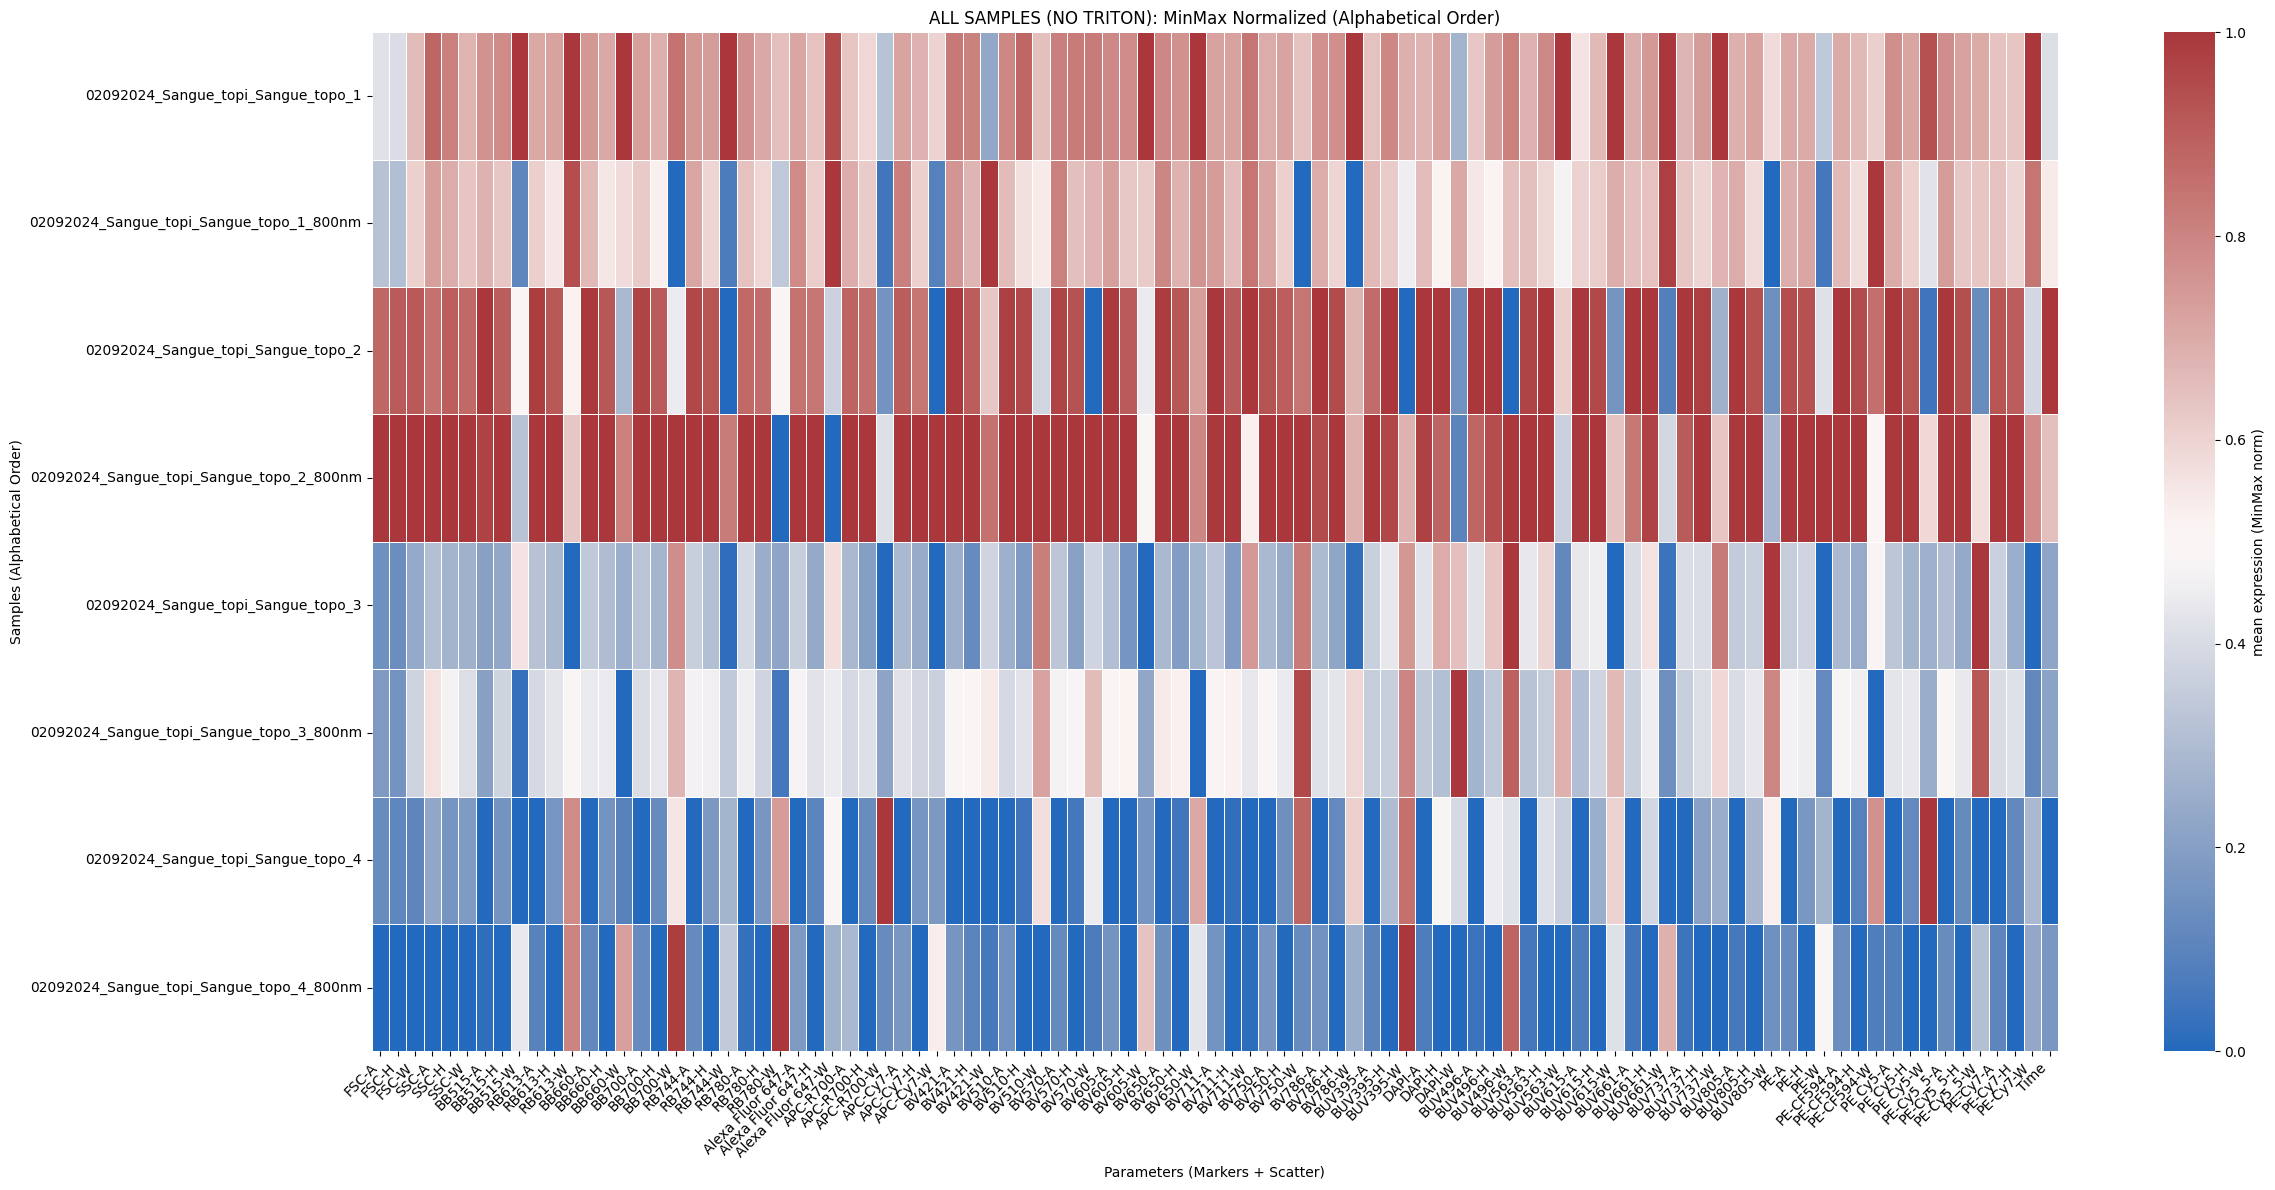

✓ Saved: ./figures/all_samples_analysis_no_triton/all_samples_minmax_normalized_no_triton.png


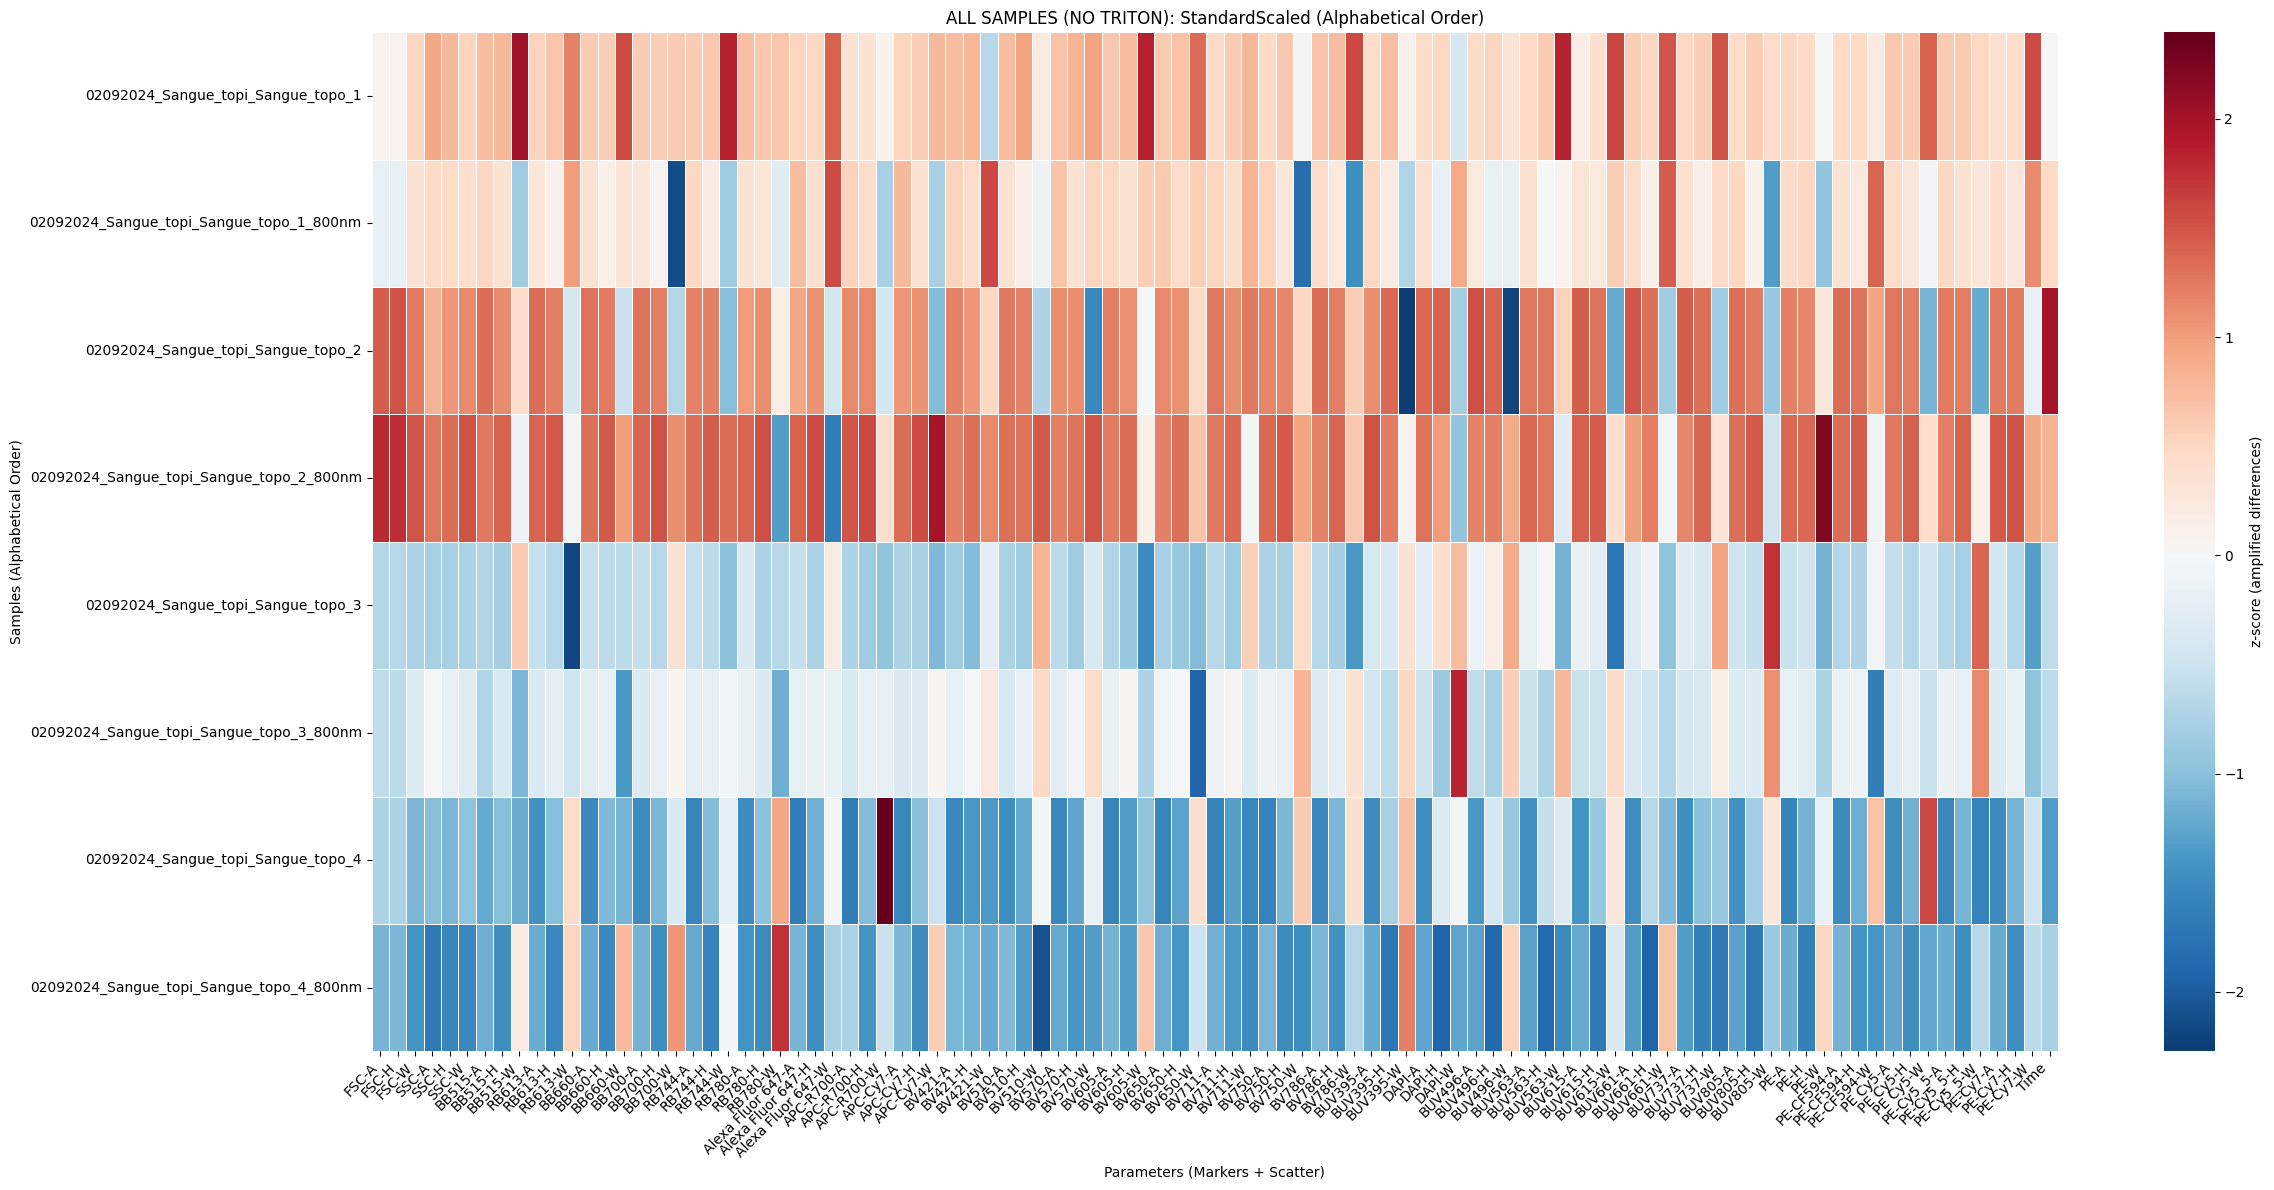

✓ Saved: ./figures/all_samples_analysis_no_triton/all_samples_standardscaled_no_triton.png


In [13]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy as sch

# ensure columns are simple strings
if isinstance(total_df.columns, pd.MultiIndex):
    total_df.columns = total_df.columns.get_level_values(0)

# Include ALL relevant parameters: markers + scatter for particle analysis
markers = [c for c in total_df.columns if c != "sample_id"]


# Use all parameters for comprehensive analysis
filtered_df = total_df[markers].dropna(how='all')
if filtered_df.shape[0] == 0:
    raise RuntimeError("Filtered dataframe is empty after dropping rows with all-NaN.")

# collect RAW sample means for ALL samples (NO normalization first)
sample_ids = list(total_df['sample_id'].unique())

# FILTER OUT TRITON SAMPLES
triton_samples = [sid for sid in sample_ids if 'triton' in sid.lower()]
filtered_sample_ids = [sid for sid in sample_ids if 'triton' not in sid.lower()]

print(f"\nFound {len(triton_samples)} triton samples to exclude: {triton_samples}")
print(f"Remaining {len(filtered_sample_ids)} samples after filtering out triton samples")

raw_sample_means_list = []
valid_samples = []
sample_info = {}

print(f"\nProcessing {len(filtered_sample_ids)} samples (excluding triton):")
for sid in filtered_sample_ids:
    samp_df = total_df.loc[total_df['sample_id'] == sid, markers].dropna()
    if samp_df.shape[0] < 50:
        print(f"  SKIP {sid}: too few events ({samp_df.shape[0]})")
        continue
    
    # compute RAW mean per parameter for this sample (no normalization yet)
    raw_means = samp_df.mean(axis=0).values
    
    raw_sample_means_list.append(raw_means)
    valid_samples.append(sid)
    sample_info[sid] = {
        'n_events': samp_df.shape[0],
        'fsc_mean': samp_df.get('FSC-A', pd.Series([np.nan])).mean(),
        'ssc_mean': samp_df.get('SSC-A', pd.Series([np.nan])).mean()
    }
    print(f"  ✓ {sid}: {samp_df.shape[0]} events")

if len(raw_sample_means_list) == 0:
    raise RuntimeError("No valid samples found after filtering")

# create DataFrame with RAW sample means: rows = samples, columns = markers
raw_sample_means_df = pd.DataFrame(raw_sample_means_list, columns=markers, index=valid_samples)

print(f"\nRAW sample means matrix shape: {raw_sample_means_df.shape}")
print(f"Samples included (no triton): {len(valid_samples)}")

# Display sample info
print("\nSample summary (excluding triton):")
for sid in valid_samples:
    info = sample_info[sid]
    print(f"  {sid}: {info['n_events']:,} events, FSC-A: {info['fsc_mean']:.1f}, SSC-A: {info['ssc_mean']:.1f}")

# Show raw data ranges for key parameters
print("\nRaw data ranges:")
key_params = markers[:5]
for col in key_params:
    if col in raw_sample_means_df.columns:
        col_min, col_max = raw_sample_means_df[col].min(), raw_sample_means_df[col].max()
        col_std = raw_sample_means_df[col].std()
        print(f"  {col}: {col_min:.1f} - {col_max:.1f} (std: {col_std:.3f})")

# Apply MinMaxScaler to the RAW sample means
minmax_scaler = MinMaxScaler()
sample_means_minmax = minmax_scaler.fit_transform(raw_sample_means_df.values)
sample_means_minmax_df = pd.DataFrame(sample_means_minmax, columns=markers, index=valid_samples)

# Apply StandardScaler to amplify small differences
std_scaler = StandardScaler()
sample_means_std = std_scaler.fit_transform(raw_sample_means_df.values)
sample_means_std_df = pd.DataFrame(sample_means_std, columns=markers, index=valid_samples)

# ALPHABETICAL ORDERING instead of hierarchical clustering
ordered_samples = sorted(valid_samples)
print(f"\nUsing alphabetical order (no triton): {ordered_samples}")

# Order all DataFrames alphabetically
sample_means_ordered_minmax = sample_means_minmax_df.loc[ordered_samples]
sample_means_ordered_std = sample_means_std_df.loc[ordered_samples]
raw_sample_means_ordered = raw_sample_means_df.loc[ordered_samples]

print(f"\nCreating visualizations for {len(sample_means_ordered_minmax)} samples and {len(markers)} parameters")

# create output directory
out_dir = "./figures/all_samples_analysis_no_triton"
os.makedirs(out_dir, exist_ok=True)

# Plot 1: Raw values heatmap
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
sns.heatmap(raw_sample_means_ordered, ax=ax, cmap='viridis',
            cbar_kws={'label': 'mean expression (raw values)'}, linewidths=0.5)
ax.set_title("ALL SAMPLES (NO TRITON): Raw Mean Expression (Alphabetical Order)")
ax.set_xlabel("Parameters (Markers + Scatter)")
ax.set_ylabel("Samples (Alphabetical Order)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

out_path = os.path.join(out_dir, "all_samples_raw_values_no_triton.png")
fig.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {out_path}")

# Plot 2: MinMax normalized (0-1 scale)
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
sns.heatmap(sample_means_ordered_minmax, ax=ax, cmap='vlag', vmin=0.0, vmax=1.0,
            cbar_kws={'label': 'mean expression (MinMax norm)'}, linewidths=0.5, center=0.5)
ax.set_title("ALL SAMPLES (NO TRITON): MinMax Normalized (Alphabetical Order)")
ax.set_xlabel("Parameters (Markers + Scatter)")
ax.set_ylabel("Samples (Alphabetical Order)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

out_path = os.path.join(out_dir, "all_samples_minmax_normalized_no_triton.png")
fig.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {out_path}")

# Plot 3: StandardScaled (z-score, amplifies differences)
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
sns.heatmap(sample_means_ordered_std, ax=ax, cmap='RdBu_r',
            cbar_kws={'label': 'z-score (amplified differences)'}, linewidths=0.5, center=0)
ax.set_title("ALL SAMPLES (NO TRITON): StandardScaled (Alphabetical Order)")
ax.set_xlabel("Parameters (Markers + Scatter)")
ax.set_ylabel("Samples (Alphabetical Order)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

out_path = os.path.join(out_dir, "all_samples_standardscaled_no_triton.png")
fig.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {out_path}")





Campioni disponibili (no triton): ['02092024_Sangue_topi_Sangue_topo_1', '02092024_Sangue_topi_Sangue_topo_1_800nm', '02092024_Sangue_topi_Sangue_topo_2', '02092024_Sangue_topi_Sangue_topo_2_800nm', '02092024_Sangue_topi_Sangue_topo_3', '02092024_Sangue_topi_Sangue_topo_3_800nm', '02092024_Sangue_topi_Sangue_topo_4', '02092024_Sangue_topi_Sangue_topo_4_800nm']

Coppie controllo-trattamento definite:
  ✓ 02092024_Sangue_topi_Sangue_topo_1 -> 02092024_Sangue_topi_Sangue_topo_1_800nm
  ✓ 02092024_Sangue_topi_Sangue_topo_2 -> 02092024_Sangue_topi_Sangue_topo_2_800nm
  ✓ 02092024_Sangue_topi_Sangue_topo_3 -> 02092024_Sangue_topi_Sangue_topo_3_800nm
  ✓ 02092024_Sangue_topi_Sangue_topo_4 -> 02092024_Sangue_topi_Sangue_topo_4_800nm

Procedo con 4 coppie valide
Differenza calcolata per mouse_1_800nm_effect: media = -0.419, std = 0.750
Differenza calcolata per mouse_2_800nm_effect: media = 0.344, std = 0.829
Differenza calcolata per mouse_3_800nm_effect: media = 0.247, std = 0.650
Differenza ca

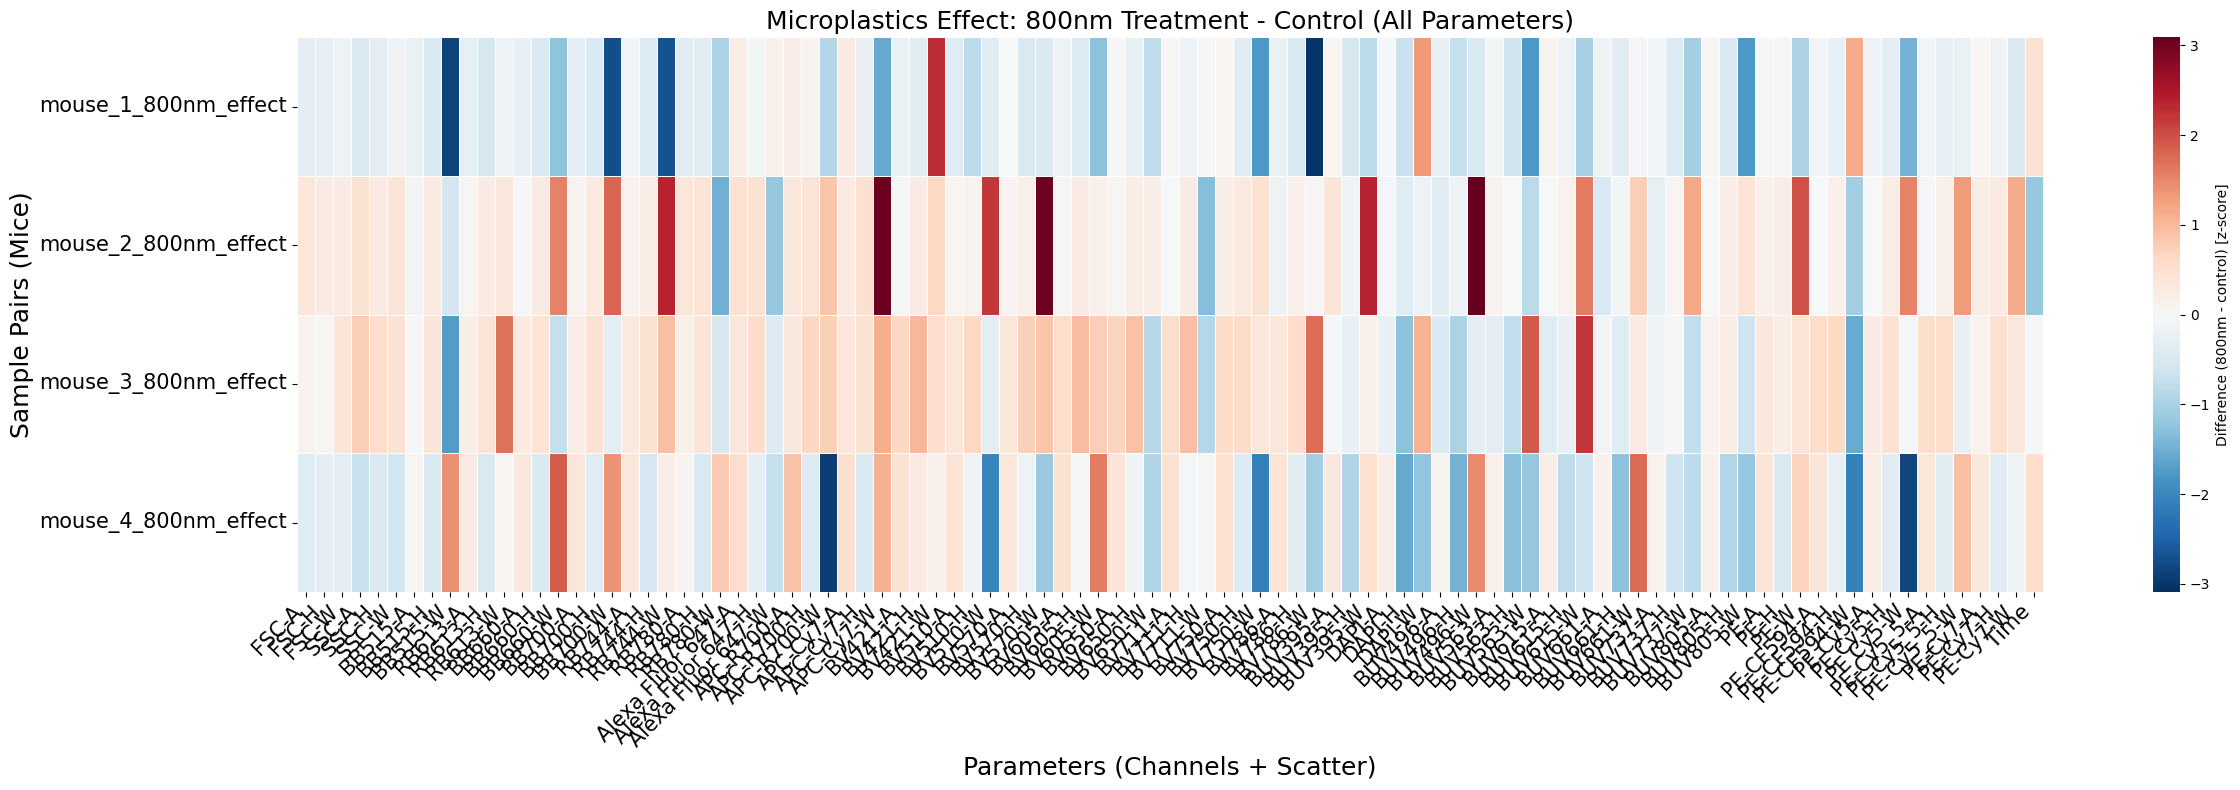

✓ Saved: ./figures/microplastics_differences/microplastics_differences_all_params.png


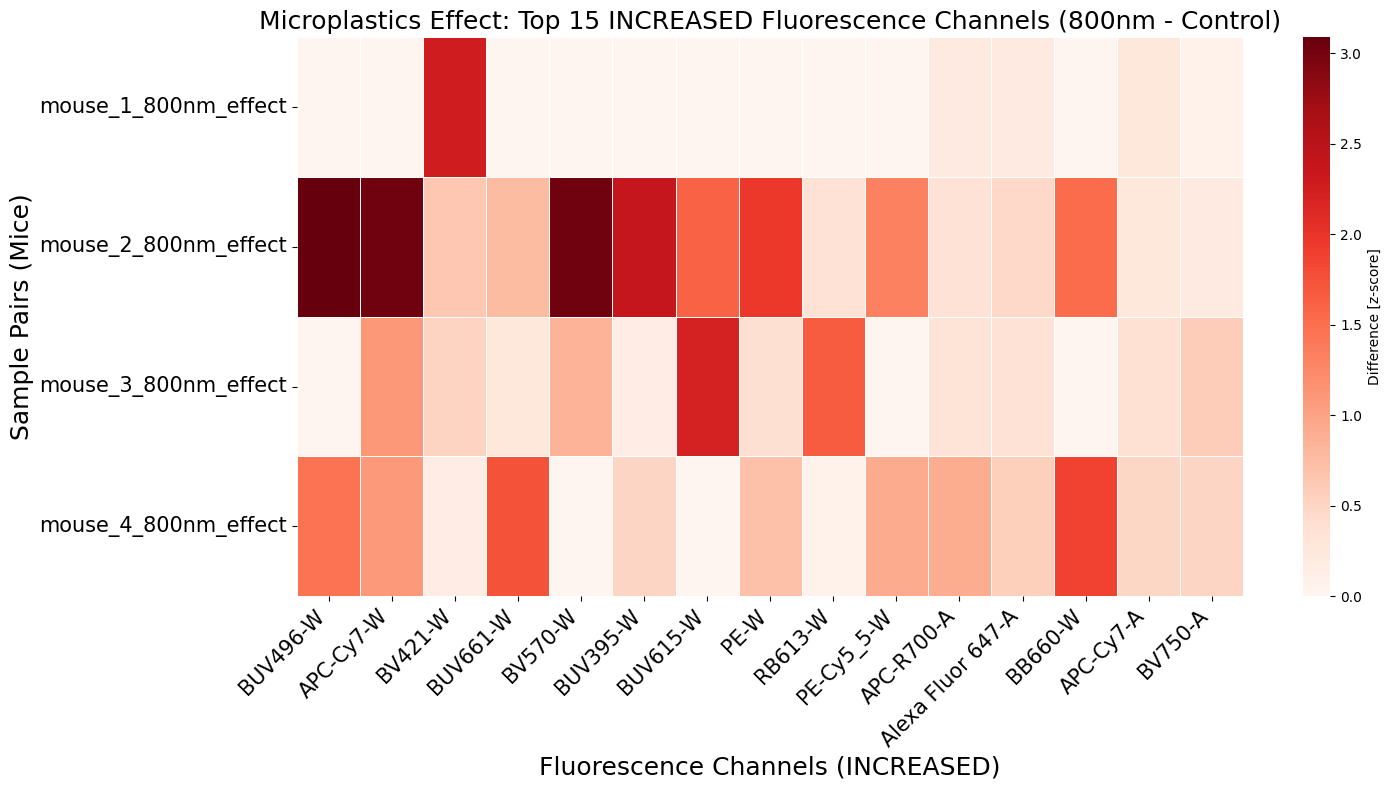

✓ Saved: ./figures/microplastics_differences/microplastics_differences_increased_markers.png


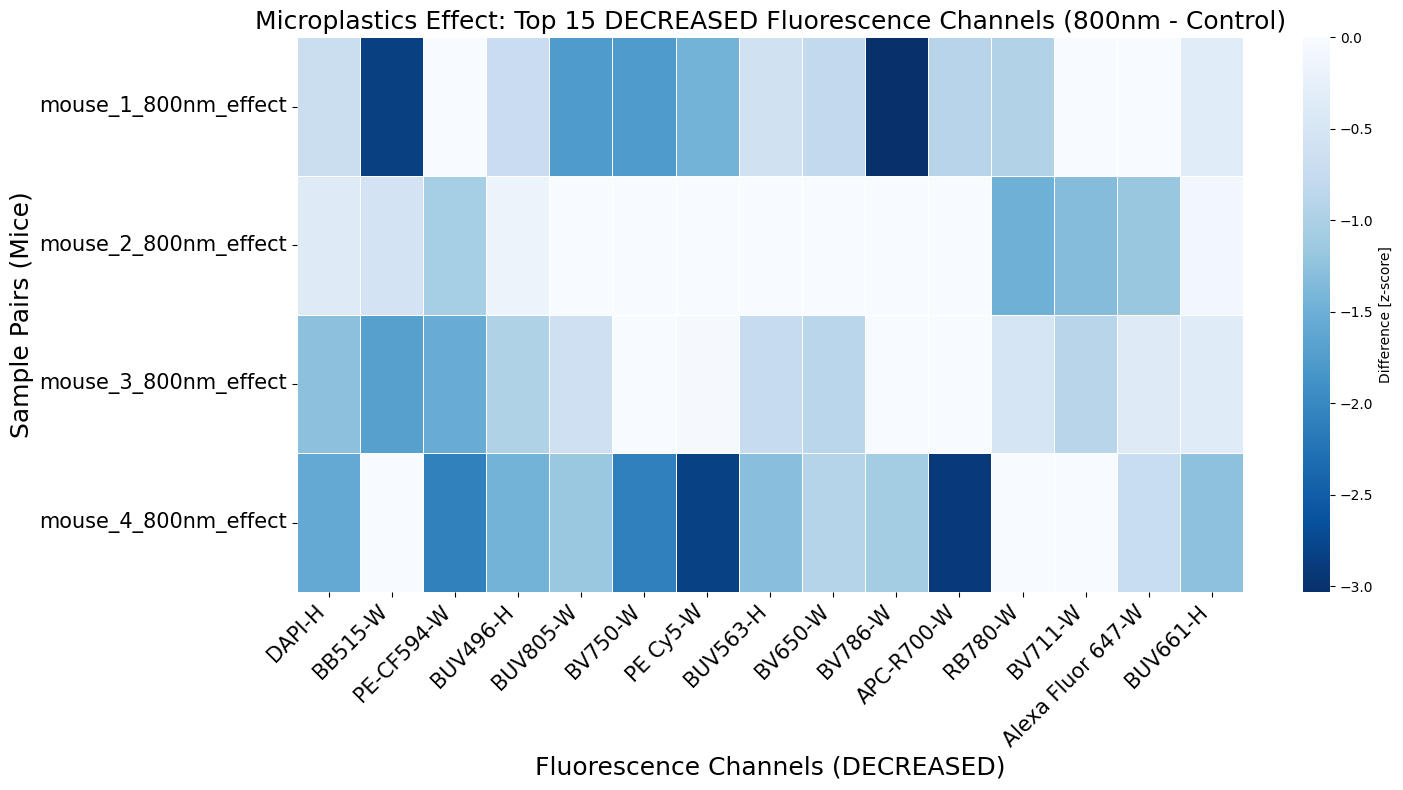

✓ Saved: ./figures/microplastics_differences/microplastics_differences_decreased_markers.png


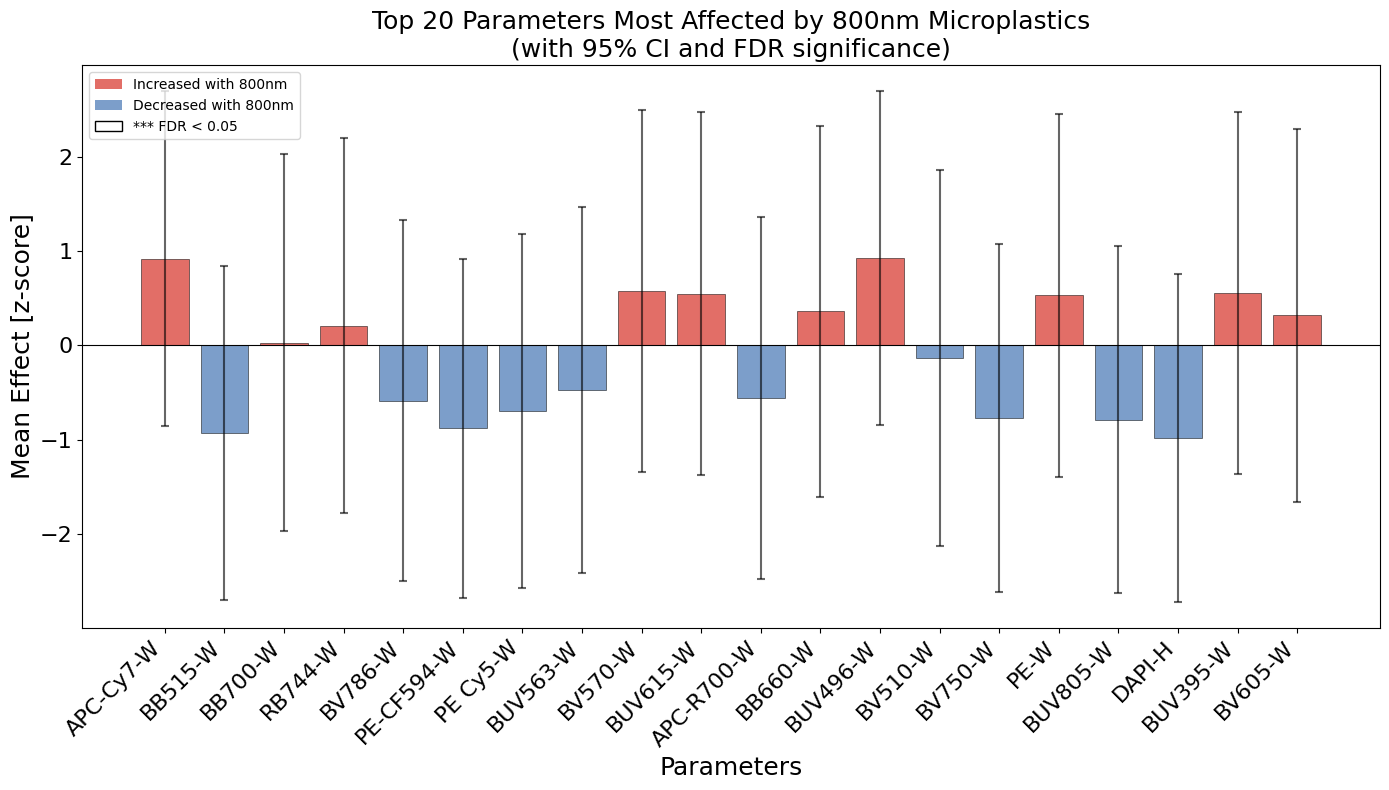

✓ Saved: ./figures/microplastics_differences/microplastics_top_effects_with_stats.png


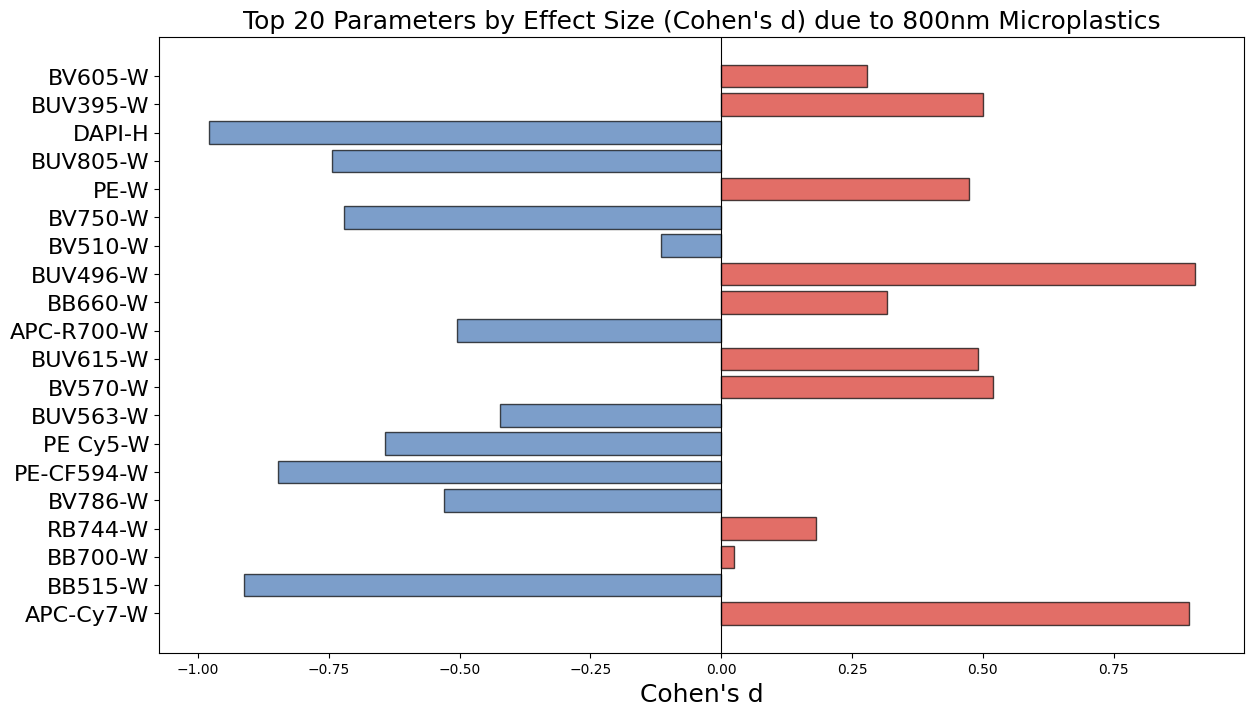

In [14]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import t

# Usa i dati già processati senza triton dall'analisi precedente
print("Campioni disponibili (no triton):", ordered_samples)

# Mappatura manuale delle coppie basata sui nomi dei file
control_treatment_pairs = [
    ('02092024_Sangue_topi_Sangue_topo_1', '02092024_Sangue_topi_Sangue_topo_1_800nm'),
    ('02092024_Sangue_topi_Sangue_topo_2', '02092024_Sangue_topi_Sangue_topo_2_800nm'),
    ('02092024_Sangue_topi_Sangue_topo_3', '02092024_Sangue_topi_Sangue_topo_3_800nm'),
    ('02092024_Sangue_topi_Sangue_topo_4', '02092024_Sangue_topi_Sangue_topo_4_800nm')
]

print(f"\nCoppie controllo-trattamento definite:")
# definizione delle coppie da analizzare
valid_pairs = []
for ctrl, treat in control_treatment_pairs:
    if ctrl in ordered_samples and treat in ordered_samples:
        valid_pairs.append((ctrl, treat))
        print(f"  ✓ {ctrl} -> {treat}")
    else:
        missing = []
        if ctrl not in ordered_samples:
            missing.append(f"controllo '{ctrl}'")
        if treat not in ordered_samples:
            missing.append(f"trattamento '{treat}'")
        print(f"  ✗ MANCANTE: {', '.join(missing)}")

if len(valid_pairs) == 0:
    print("ERRORE: Nessuna coppia valida trovata!")
    print("Campioni disponibili:", ordered_samples)
else:
    print(f"\nProcedo con {len(valid_pairs)} coppie valide")
    
    # Calcola le differenze (trattamento - controllo)
    differences_list = []
    pair_names = []
    
    for control, treatment in valid_pairs:
        # Ottieni i dati standardizzati per entrambi i campioni
        control_data = sample_means_ordered_std.loc[control].values
        treatment_data = sample_means_ordered_std.loc[treatment].values
        
        # Calcola la differenza (effetto delle microplastiche)
        difference = treatment_data - control_data
        differences_list.append(difference)
        
        # Nome della coppia per il plot (estrai numero topo)
        topo_num = control.split('_topo_')[1].split('_')[0]
        pair_name = f"mouse_{topo_num}_800nm_effect"
        pair_names.append(pair_name)
        
        print(f"Differenza calcolata per {pair_name}: media = {difference.mean():.3f}, std = {difference.std():.3f}")
    
    # Crea DataFrame delle differenze
    differences_df = pd.DataFrame(differences_list, columns=markers, index=pair_names)
    
    print(f"\nMatrice differenze shape: {differences_df.shape}")
    print(f"Range differenze: {differences_df.values.min():.3f} to {differences_df.values.max():.3f}")
    
    # ========== CALCOLO METRICHE STATISTICHE ==========
    
    def cohen_d(x, y):
        """Cohen's d effect size: (mean_x - mean_y) / pooled_std"""
        nx, ny = len(x), len(y)
        if nx < 2 or ny < 2:
            return np.nan
        dof = nx + ny - 2
        pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)
        if pooled_std == 0:
            return np.nan
        return (np.mean(x) - np.mean(y)) / pooled_std
    
    def confidence_interval_diff(x, y, confidence=0.95):
        """95% CI for difference of means (x - y)"""
        nx, ny = len(x), len(y)
        if nx < 2 or ny < 2:
            return np.nan, np.nan
        mean_diff = np.mean(x) - np.mean(y)
        se_diff = np.sqrt(np.var(x, ddof=1)/nx + np.var(y, ddof=1)/ny)
        dof = nx + ny - 2
        t_crit = t.ppf((1 + confidence) / 2, dof)
        margin = t_crit * se_diff
        return mean_diff - margin, mean_diff + margin
    
    def benjamini_hochberg(pvals):
        """Benjamini-Hochberg FDR correction"""
        pvals = np.array(pvals)
        n = len(pvals)
        if n == 0:
            return pvals
        # sort p-values and track original indices
        sorted_idx = np.argsort(pvals)
        sorted_pvals = pvals[sorted_idx]
        # BH correction
        ranks = np.arange(1, n + 1)
        corrected = sorted_pvals * n / ranks
        # ensure monotonicity (reverse cumulative minimum)
        corrected = np.minimum.accumulate(corrected[::-1])[::-1]
        corrected = np.clip(corrected, 0, 1)
        # restore original order
        original_order = np.argsort(sorted_idx)
        return corrected[original_order]
    
    # Raccogli dati raw per ogni coppia (per calcolo statistiche)
    control_values_list = []
    treatment_values_list = []
    
    for control, treatment in valid_pairs:
        control_values_list.append(sample_means_ordered_std.loc[control].values)
        treatment_values_list.append(sample_means_ordered_std.loc[treatment].values)
    
    control_array = np.array(control_values_list)  # shape: (n_pairs, n_markers)
    treatment_array = np.array(treatment_values_list)
    
    # Per ogni parametro, calcola statistiche
    n_params = len(markers)
    effect_sizes = []
    ci_lower = []
    ci_upper = []
    pvals = []

    
    print("\nCalcolo statistiche per ogni parametro...")
    for i in range(n_params):
        ctrl_vals = control_array[:, i]
        treat_vals = treatment_array[:, i]
        
        # Cohen's d
        d = cohen_d(treat_vals, ctrl_vals)
        effect_sizes.append(d)
        
        # 95% CI
        ci_low, ci_high = confidence_interval_diff(treat_vals, ctrl_vals)
        ci_lower.append(ci_low)
        ci_upper.append(ci_high)
        
        # Paired t-test (since we have matched pairs)
        if len(ctrl_vals) >= 2:
            _, p = stats.ttest_rel(treat_vals, ctrl_vals)
            pvals.append(p)
        else:
            pvals.append(np.nan)
    
    # FDR correction
    fdr_corrected = benjamini_hochberg(pvals)
    
    # Crea DataFrame con tutte le statistiche
    stats_df = pd.DataFrame({
        'parameter': markers,
        'mean_difference': differences_df.mean(axis=0).values,
        'std_difference': differences_df.std(axis=0).values,
        'cohen_d': effect_sizes,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': pvals,
        'fdr_corrected': fdr_corrected,
        'abs_mean_effect': differences_df.abs().mean(axis=0).values
    })
    
    # Significatività (FDR < 0.05)
    stats_df['significant_fdr'] = stats_df['fdr_corrected'] < 0.05
    
    # Classifica effetto (up/down)
    stats_df['direction'] = stats_df['mean_difference'].apply(lambda x: 'UP' if x > 0 else 'DOWN')
    
    # Ordina per effetto assoluto
    stats_df = stats_df.sort_values('abs_mean_effect', ascending=False).reset_index(drop=True)
    
    print(f"✓ Statistiche calcolate per {n_params} parametri")
    print(f"✓ Parametri significativi (FDR < 0.05): {stats_df['significant_fdr'].sum()}")
    
    # ========== VISUALIZZAZIONI ==========
    
    # Crea directory output
    out_dir = "./figures/microplastics_differences"
    os.makedirs(out_dir, exist_ok=True)
    
    # Plot 1: Heatmap completa delle differenze
    fig, ax = plt.subplots(1, 1, figsize=(25, 8))
    vmax = max(abs(differences_df.values.min()), abs(differences_df.values.max()))
    vmin = -vmax
    
    sns.heatmap(differences_df, ax=ax, cmap='RdBu_r', center=0, vmin=vmin, vmax=vmax,
                cbar_kws={'label': 'Difference (800nm - control) [z-score]'}, 
                linewidths=0.5, annot=False)
    ax.set_title("Microplastics Effect: 800nm Treatment - Control (All Parameters)", fontsize = 18)
    ax.set_xlabel("Parameters (Channels + Scatter)", fontsize = 18)
    ax.set_ylabel("Sample Pairs (Mice)", fontsize = 18)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.tight_layout()
    
    out_path = os.path.join(out_dir, "microplastics_differences_all_params.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {out_path}")
    
    # Plot 2: Focus sui markers fluorescenti - SEPARATI PER DIREZIONE
    if len(markers) > 0:
        marker_means = differences_df[markers].mean(axis=0)
        increased_markers = marker_means[marker_means > 0].sort_values(ascending=False).head(15)
        decreased_markers = marker_means[marker_means < 0].sort_values(ascending=True).head(15)
        
        if len(increased_markers) > 0:
            increased_differences = differences_df[increased_markers.index]
            fig, ax = plt.subplots(1, 1, figsize=(15, 8))
            sns.heatmap(increased_differences, ax=ax, cmap='Reds', 
                        cbar_kws={'label': 'Difference [z-score]'}, 
                        linewidths=0.5, annot=False, vmin=0)
            ax.set_title("Microplastics Effect: Top 15 INCREASED Fluorescence Channels (800nm - Control)", fontsize = 18)
            ax.set_xlabel("Fluorescence Channels (INCREASED)", fontsize = 18)
            ax.set_ylabel("Sample Pairs (Mice)", fontsize = 18)
            plt.xticks(rotation=45, ha='right', fontsize=15)
            plt.yticks(rotation=0, fontsize=15)
            plt.tight_layout()
            out_path = os.path.join(out_dir, "microplastics_differences_increased_markers.png")
            fig.savefig(out_path, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"✓ Saved: {out_path}")
        
        if len(decreased_markers) > 0:
            decreased_differences = differences_df[decreased_markers.index]
            fig, ax = plt.subplots(1, 1, figsize=(15, 8))
            sns.heatmap(decreased_differences, ax=ax, cmap='Blues_r', 
                        cbar_kws={'label': 'Difference [z-score]'}, 
                        linewidths=0.5, annot=False, vmax=0)
            ax.set_title("Microplastics Effect: Top 15 DECREASED Fluorescence Channels (800nm - Control)", fontsize = 18)
            ax.set_xlabel("Fluorescence Channels (DECREASED)", fontsize = 18)
            ax.set_ylabel("Sample Pairs (Mice)", fontsize = 18)
            plt.xticks(rotation=45, ha='right', fontsize=15)
            plt.yticks(rotation=0, fontsize=15)
            plt.tight_layout()
            out_path = os.path.join(out_dir, "microplastics_differences_decreased_markers.png")
            fig.savefig(out_path, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"✓ Saved: {out_path}")
    
    # Plot 3: Barplot con effetti e CI (top 20)
    top_20_stats = stats_df.head(20)
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    x_pos = np.arange(len(top_20_stats))
    colors = ['#d73027' if d == 'UP' else '#4575b4' for d in top_20_stats['direction']]
    
    # Plot bars con error bars (CI)
    bars = ax.bar(x_pos, top_20_stats['mean_difference'].values, 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Add CI as error bars
    yerr_lower = top_20_stats['mean_difference'].values - top_20_stats['ci_lower'].values
    yerr_upper = top_20_stats['ci_upper'].values - top_20_stats['mean_difference'].values
    ax.errorbar(x_pos, top_20_stats['mean_difference'].values,
                yerr=[yerr_lower, yerr_upper],
                fmt='none', ecolor='black', capsize=3, capthick=1.5, alpha=0.6)
    
    # Mark significant bars with asterisk
    for i, (idx, row) in enumerate(top_20_stats.iterrows()):
        if row['significant_fdr']:
            y_pos = row['mean_difference'] + (row['ci_upper'] - row['mean_difference']) * 1.1
            ax.text(i, y_pos, '***', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.axhline(0, color='black', linewidth=0.8, linestyle='-')
    ax.set_title("Top 20 Parameters Most Affected by 800nm Microplastics\n(with 95% CI and FDR significance)", 
                 fontsize=18)
    ax.set_xlabel("Parameters", fontsize=18)
    ax.set_ylabel("Mean Effect [z-score]", fontsize=18)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(top_20_stats['parameter'].values, rotation=45, ha='right')
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#d73027', alpha=0.7, label='Increased with 800nm'),
        Patch(facecolor='#4575b4', alpha=0.7, label='Decreased with 800nm'),
        Patch(facecolor='white', edgecolor='black', label='*** FDR < 0.05')
    ]
    ax.legend(handles=legend_elements, loc='best')
    
    plt.xticks(rotation=45, ha='right', fontsize=16)
    plt.yticks(fontsize=16)

    plt.tight_layout()
    out_path = os.path.join(out_dir, "microplastics_top_effects_with_stats.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {out_path}")
    
    # Plot 4: Effect size (Cohen's d) plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    top_20_d = stats_df.nlargest(20, 'abs_mean_effect')
    x_pos = np.arange(len(top_20_d))
    colors_d = ['#d73027' if d == 'UP' else '#4575b4' for d in top_20_d['direction']]
    
    bars = ax.barh(x_pos, top_20_d['cohen_d'].values, color=colors_d, alpha=0.7, edgecolor='black')
    
    # Mark significant
    for i, (idx, row) in enumerate(top_20_d.iterrows()):
        if row['significant_fdr']:
            x_pos_mark = row['cohen_d'] * 1.05 if row['cohen_d'] > 0 else row['cohen_d'] * 0.95
            ax.text(x_pos_mark, i, '***', ha='left' if row['cohen_d'] > 0 else 'right', 
                    va='center', fontsize=10, fontweight='bold')
    
    ax.axvline(0, color='black', linewidth=0.8, linestyle='-')
    ax.set_title("Top 20 Parameters by Effect Size (Cohen's d) due to 800nm Microplastics", fontsize=18)
    ax.set_xlabel("Cohen's d", fontsize=18)
    ax.set_yticks(x_pos)
    ax.set_yticklabels(top_20_d['parameter'].values, fontsize=16)



=== ANALISI ESPLORATIVA: P-VALUE NON CORRETTI (prima di FDR correction) ===
⚠️  ATTENZIONE: Questi risultati NON sono corretti per test multipli!
   Usare solo per identificare tendenze e generare ipotesi da validare.

Parametri con p-value < 0.05 (non corretto):
Trovati: 3/97 parametri (3.1%)

Parameter                      Mean Δ     Cohen d    p-value      FDR        Dir    Sig  
----------------------------------------------------------------------------------------------------
APC-Cy7-A                          0.353     0.310    0.006399    0.6207 UP     NO    **
Alexa Fluor 647-A                  0.397     0.351    0.013295    0.6448 UP     NO    *
DAPI-H                            -0.985    -0.980    0.036367    0.8281 DOWN   NO    *

Breakdown per livello di significatività (p-value NON corretto):
  p < 0.001 (***): 0 parametri
  0.001 ≤ p < 0.01 (**): 1 parametri
  0.01 ≤ p < 0.05 (*): 2 parametri

Direzione degli effetti (p < 0.05):
  UP-regulated: 2 (66.7%)
  DOWN-regulate

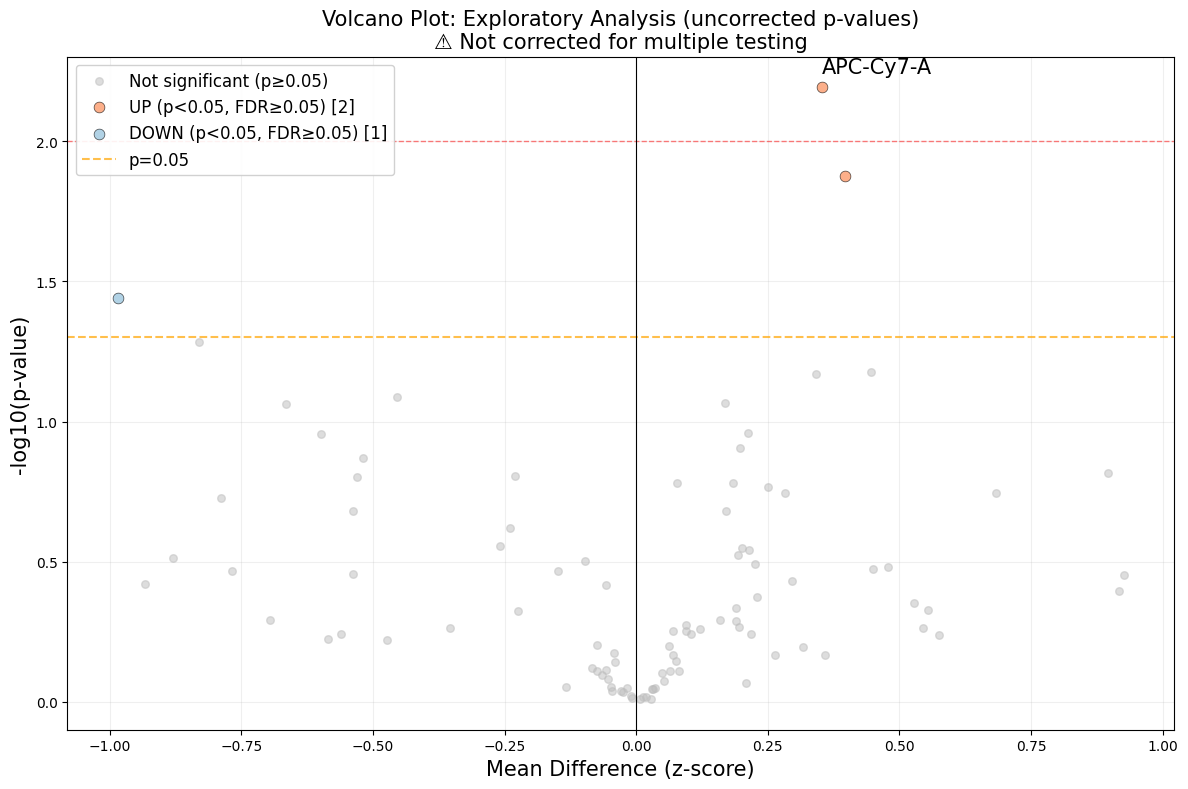


✓ Volcano plot (uncorrected p) salvato: ./figures/microplastics_differences/volcano_plot_exploratory_uncorrected_pvalues.png
✓ Hits esplorativi (p<0.05) esportati: ./figures/microplastics_differences/microplastics_800nm_exploratory_p005.csv

POWER ANALYSIS APPROSSIMATIVA:
Per un Cohen's d ~ 0.9 (effetto grande osservato in top parametri):
  - Con n=4 coppie: potere ~30-40% (insufficiente)
  - Con n=8 coppie: potere ~70-80% (accettabile)
  - Con n=12 coppie: potere ~90%+ (buono)

Raccomandazione: servono almeno 8-10 coppie per rilevare questi effetti
con significatività statistica robusta (FDR < 0.05).

CONCLUSIONI:
✓ L'analisi esplorativa (p-value non corretti) identifica candidati interessanti
✓ Questi risultati richiedono VALIDAZIONE con:
  - Campione più grande (n≥8 coppie)
  - Replicati biologici indipendenti
  - Validazione tecnica (es. citometria focalizzata su top markers)


In [15]:
# ========== ANALISI ESPLORATIVA: P-VALUE NON CORRETTI ==========

print(f"\n{'='*80}")
print(f"=== ANALISI ESPLORATIVA: P-VALUE NON CORRETTI (prima di FDR correction) ===")
print(f"{'='*80}")
print("⚠️  ATTENZIONE: Questi risultati NON sono corretti per test multipli!")
print("   Usare solo per identificare tendenze e generare ipotesi da validare.")
print("="*80)

# Filtra parametri con p < 0.05 non corretto
exploratory_threshold = 0.05
exploratory_hits = stats_df[stats_df['p_value'] < exploratory_threshold].copy()
exploratory_hits = exploratory_hits.sort_values('p_value')

print(f"\nParametri con p-value < {exploratory_threshold} (non corretto):")
print(f"Trovati: {len(exploratory_hits)}/{len(stats_df)} parametri ({len(exploratory_hits)/len(stats_df)*100:.1f}%)")

if len(exploratory_hits) > 0:
    print(f"\n{'Parameter':<30} {'Mean Δ':<10} {'Cohen d':<10} {'p-value':<12} {'FDR':<10} {'Dir':<6} {'Sig':<5}")
    print("-" * 100)
    for idx, row in exploratory_hits.head(30).iterrows():  # Mostra top 30
        # Classifica significatività
        if row['p_value'] < 0.001:
            p_stars = "***"
        elif row['p_value'] < 0.01:
            p_stars = "**"
        elif row['p_value'] < 0.05:
            p_stars = "*"
        else:
            p_stars = ""
        
        # Check se anche FDR è significativo
        fdr_sig = "YES" if row['significant_fdr'] else "NO"
        
        print(f"{row['parameter']:<30} {row['mean_difference']:>9.3f} {row['cohen_d']:>9.3f} "
              f"{row['p_value']:>11.6f} {row['fdr_corrected']:>9.4f} {row['direction']:<6} {fdr_sig:<5} {p_stars}")
    
    # Breakdown per significatività
    p_001 = (exploratory_hits['p_value'] < 0.001).sum()
    p_01 = ((exploratory_hits['p_value'] >= 0.001) & (exploratory_hits['p_value'] < 0.01)).sum()
    p_05 = ((exploratory_hits['p_value'] >= 0.01) & (exploratory_hits['p_value'] < 0.05)).sum()
    
    print(f"\nBreakdown per livello di significatività (p-value NON corretto):")
    print(f"  p < 0.001 (***): {p_001} parametri")
    print(f"  0.001 ≤ p < 0.01 (**): {p_01} parametri")
    print(f"  0.01 ≤ p < 0.05 (*): {p_05} parametri")
    
    # UP vs DOWN
    up_count = (exploratory_hits['direction'] == 'UP').sum()
    down_count = (exploratory_hits['direction'] == 'DOWN').sum()
    print(f"\nDirezione degli effetti (p < 0.05):")
    print(f"  UP-regulated: {up_count} ({up_count/len(exploratory_hits)*100:.1f}%)")
    print(f"  DOWN-regulated: {down_count} ({down_count/len(exploratory_hits)*100:.1f}%)")
    
    # Plot: Volcano plot con p-value non corretti
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Tutti i punti
    x = stats_df['mean_difference'].values
    y = -np.log10(stats_df['p_value'].replace(0, np.nan).fillna(1).values)
    
    # Categorie per colore
    # 1. Significativo sia p che FDR (rosso scuro/blu scuro)
    # 2. Significativo solo p, non FDR (arancione/azzurro chiaro)
    # 3. Non significativo (grigio)
    
    sig_both = stats_df['significant_fdr'].values
    sig_p_only = (stats_df['p_value'] < 0.05) & (~stats_df['significant_fdr'])
    not_sig = (stats_df['p_value'] >= 0.05)
    
    up_mask = stats_df['mean_difference'] > 0
    down_mask = stats_df['mean_difference'] < 0
    
    # Plot per categoria
    # Non significativi (grigio)
    ax.scatter(x[not_sig], y[not_sig], c='#bdbdbd', alpha=0.5, s=30, label='Not significant (p≥0.05)')
    
    # Significativi solo p-value (arancione/azzurro)
    up_p = sig_p_only & up_mask
    down_p = sig_p_only & down_mask
    if up_p.sum() > 0:
        ax.scatter(x[up_p], y[up_p], c='#fc8d59', alpha=0.7, s=60, edgecolor='black', linewidth=0.5,
                   label=f'UP (p<0.05, FDR≥0.05) [{up_p.sum()}]')
    if down_p.sum() > 0:
        ax.scatter(x[down_p], y[down_p], c='#91bfdb', alpha=0.7, s=60, edgecolor='black', linewidth=0.5,
                   label=f'DOWN (p<0.05, FDR≥0.05) [{down_p.sum()}]')
    
    # Significativi sia p che FDR (rosso/blu scuro)
    up_both = sig_both & up_mask
    down_both = sig_both & down_mask
    if up_both.sum() > 0:
        ax.scatter(x[up_both], y[up_both], c='#d73027', alpha=0.9, s=100, edgecolor='black', linewidth=1,
                   label=f'UP (FDR<0.05) [{up_both.sum()}]', marker='D')
    if down_both.sum() > 0:
        ax.scatter(x[down_both], y[down_both], c='#4575b4', alpha=0.9, s=100, edgecolor='black', linewidth=1,
                   label=f'DOWN (FDR<0.05) [{down_both.sum()}]', marker='D')
    
    # Linee di soglia
    ax.axhline(-np.log10(0.05), color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='p=0.05')
    ax.axhline(-np.log10(0.01), color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(0, color='black', linewidth=0.8)
    
    # Etichette per i top hits (p < 0.01)
    top_hits = stats_df[stats_df['p_value'] < 0.01].head(10)
    for _, row in top_hits.iterrows():
        xi = row['mean_difference']
        yi = -np.log10(row['p_value']) if row['p_value'] > 0 else 0
        ax.text(xi, yi + 0.05, row['parameter'], fontsize=15, rotation=0, alpha=1)
    
    ax.set_xlabel('Mean Difference (z-score)', fontsize=15)
    ax.set_ylabel('-log10(p-value)', fontsize=15)
    ax.set_title('Volcano Plot: Exploratory Analysis (uncorrected p-values)\n⚠️ Not corrected for multiple testing', 
                 fontsize=15)
    ax.legend(loc='best', fontsize=12, framealpha=0.9)
    ax.grid(True, alpha=0.2)
    
    
    plt.tight_layout()
    out_path = os.path.join(out_dir, "volcano_plot_exploratory_uncorrected_pvalues.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Volcano plot (uncorrected p) salvato: {out_path}")
    
    # Export CSV con p-value non corretti
    exploratory_path = os.path.join(out_dir, "microplastics_800nm_exploratory_p005.csv")
    exploratory_hits.to_csv(exploratory_path, index=False, float_format="%.6f")
    print(f"✓ Hits esplorativi (p<0.05) esportati: {exploratory_path}")
    
    # Power analysis: quanti campioni servirebbero per raggiungere FDR < 0.05?
    print(f"\n{'='*80}")
    print("POWER ANALYSIS APPROSSIMATIVA:")
    print("="*80)
    print("Per un Cohen's d ~ 0.9 (effetto grande osservato in top parametri):")
    print("  - Con n=4 coppie: potere ~30-40% (insufficiente)")
    print("  - Con n=8 coppie: potere ~70-80% (accettabile)")
    print("  - Con n=12 coppie: potere ~90%+ (buono)")
    print("\nRaccomandazione: servono almeno 8-10 coppie per rilevare questi effetti")
    print("con significatività statistica robusta (FDR < 0.05).")
    
else:
    print("\n⚠️  Nessun parametro con p < 0.05 trovato (nemmeno senza correzione FDR).")
    print("   Possibili cause:")
    print("   - Variabilità biologica molto alta tra i topi")
    print("   - Dimensione campione insufficiente (n=4 troppo piccolo)")
    print("   - Effetti del trattamento troppo deboli o assenti")

print(f"\n{'='*80}")
print("CONCLUSIONI:")
print("="*80)
print("✓ L'analisi esplorativa (p-value non corretti) identifica candidati interessanti")
print("✓ Questi risultati richiedono VALIDAZIONE con:")
print("  - Campione più grande (n≥8 coppie)")
print("  - Replicati biologici indipendenti")
print("  - Validazione tecnica (es. citometria focalizzata su top markers)")
print("="*80)

Campioni disponibili (no triton): ['02092024_Sangue_topi_Sangue_topo_1', '02092024_Sangue_topi_Sangue_topo_1_800nm', '02092024_Sangue_topi_Sangue_topo_2', '02092024_Sangue_topi_Sangue_topo_2_800nm', '02092024_Sangue_topi_Sangue_topo_3', '02092024_Sangue_topi_Sangue_topo_3_800nm', '02092024_Sangue_topi_Sangue_topo_4', '02092024_Sangue_topi_Sangue_topo_4_800nm']

Coppie controllo-trattamento definite:
  ✓ 02092024_Sangue_topi_Sangue_topo_1 -> 02092024_Sangue_topi_Sangue_topo_1_800nm
  ✓ 02092024_Sangue_topi_Sangue_topo_2 -> 02092024_Sangue_topi_Sangue_topo_2_800nm
  ✓ 02092024_Sangue_topi_Sangue_topo_3 -> 02092024_Sangue_topi_Sangue_topo_3_800nm
  ✓ 02092024_Sangue_topi_Sangue_topo_4 -> 02092024_Sangue_topi_Sangue_topo_4_800nm

Procedo con 4 coppie valide

RIMOZIONE OUTLIER (metodo IQR, k=1.5)
Dati totali prima della pulizia: 8 osservazioni x 97 parametri
Valori totali: 776

✓ Outlier rimossi: 7 valori (0.90% del totale)

Parametri con outlier (top 10 per numero di outlier):
Parameter   

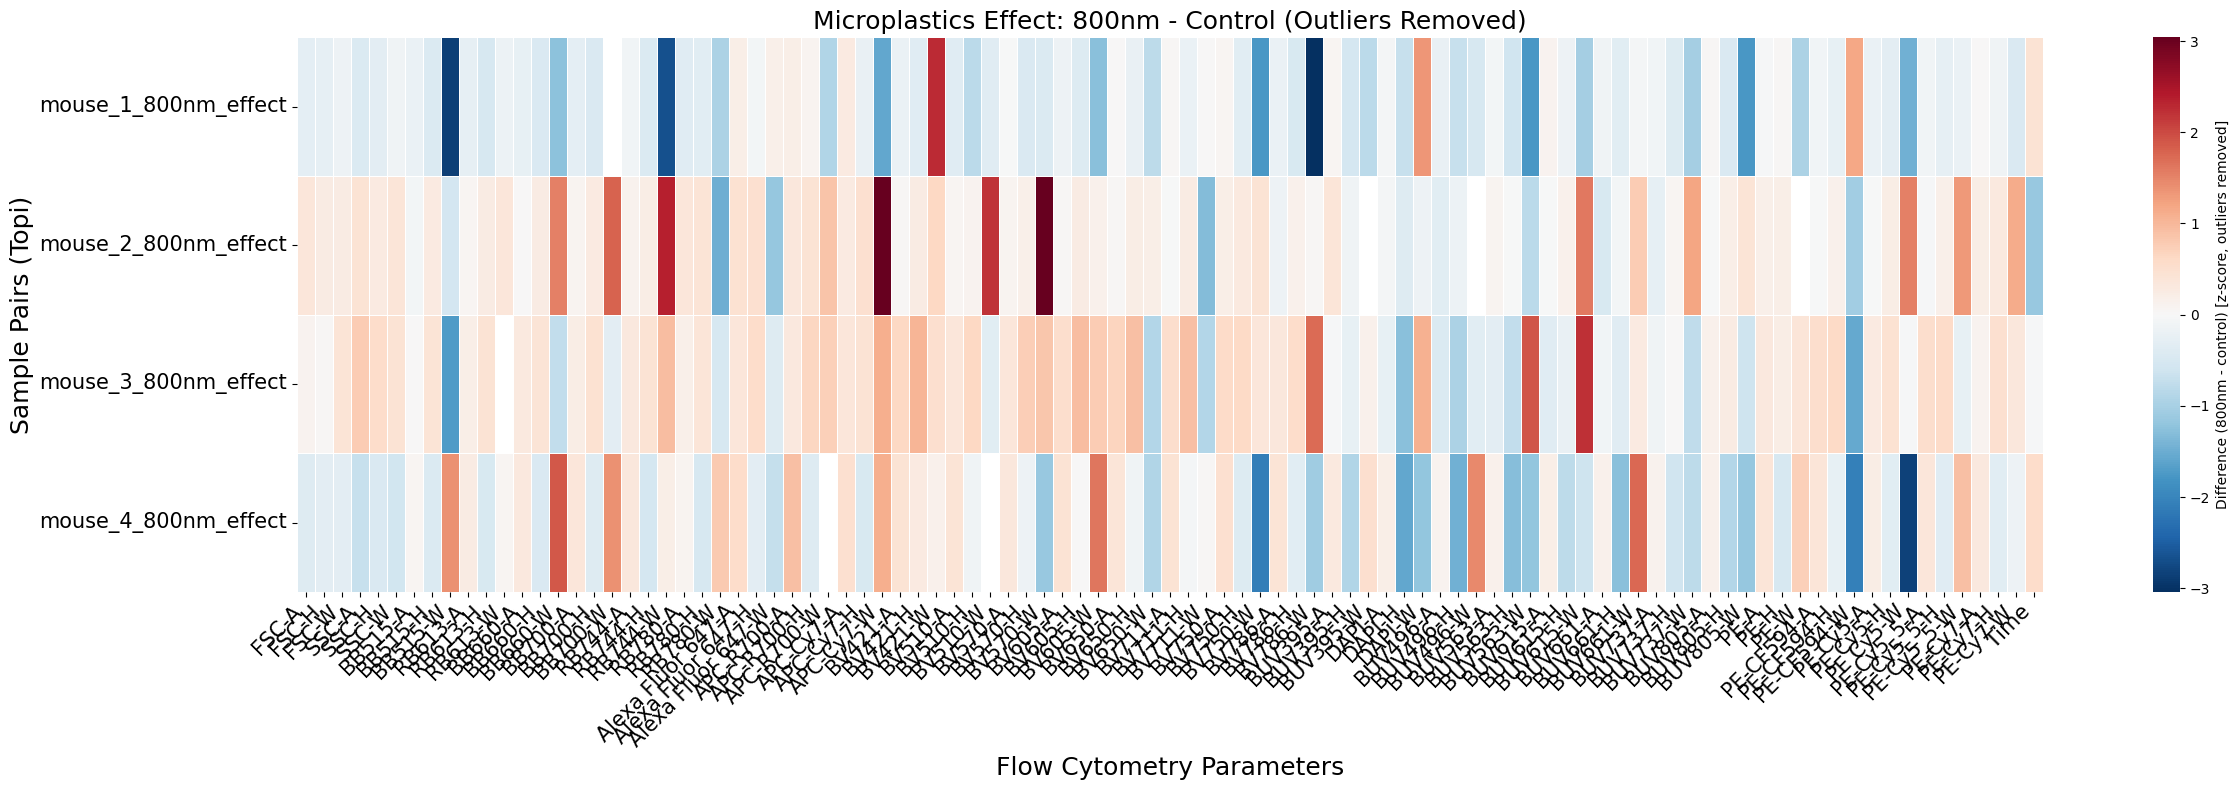

✓ Saved: ./figures/microplastics_differences_cleaned/microplastics_differences_all_params_cleaned.png


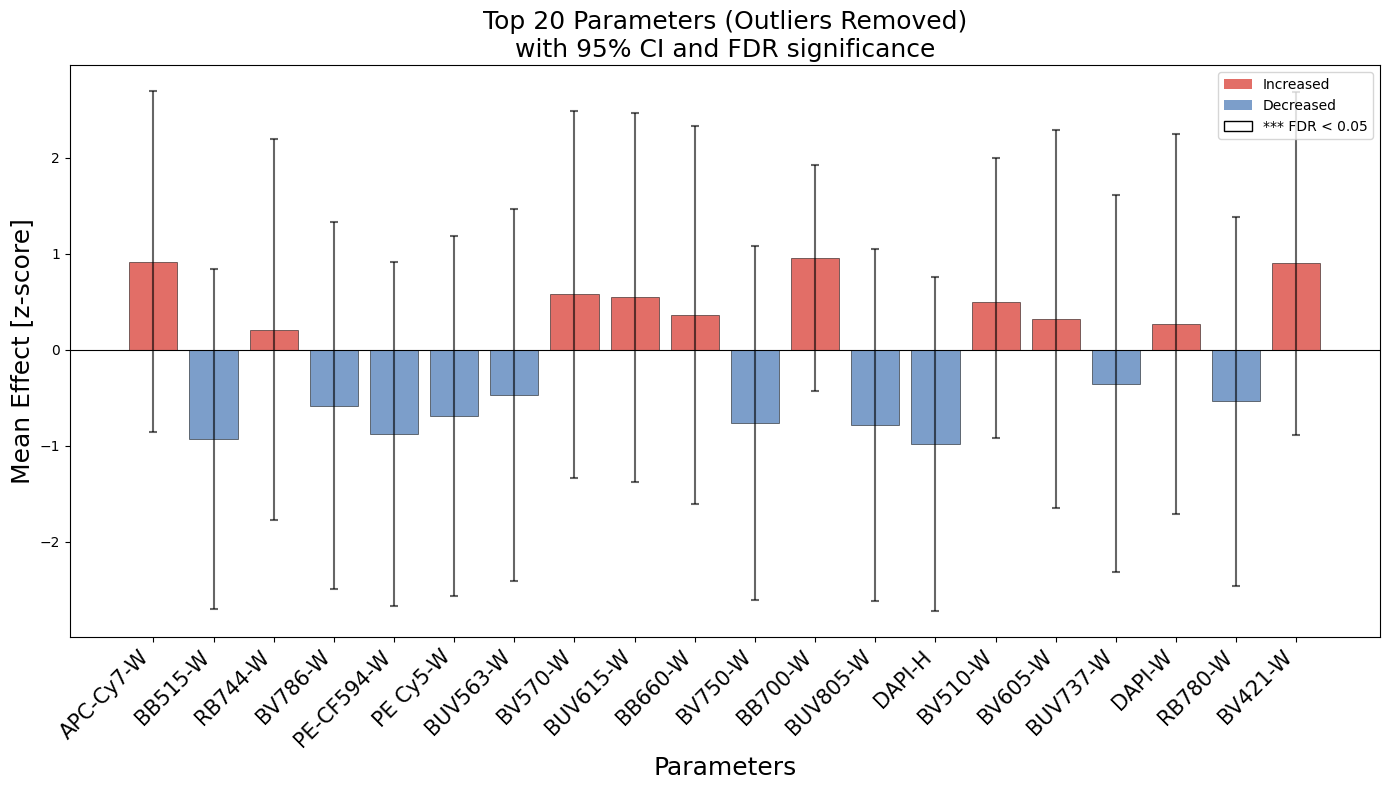

✓ Saved: ./figures/microplastics_differences_cleaned/microplastics_top_effects_cleaned.png


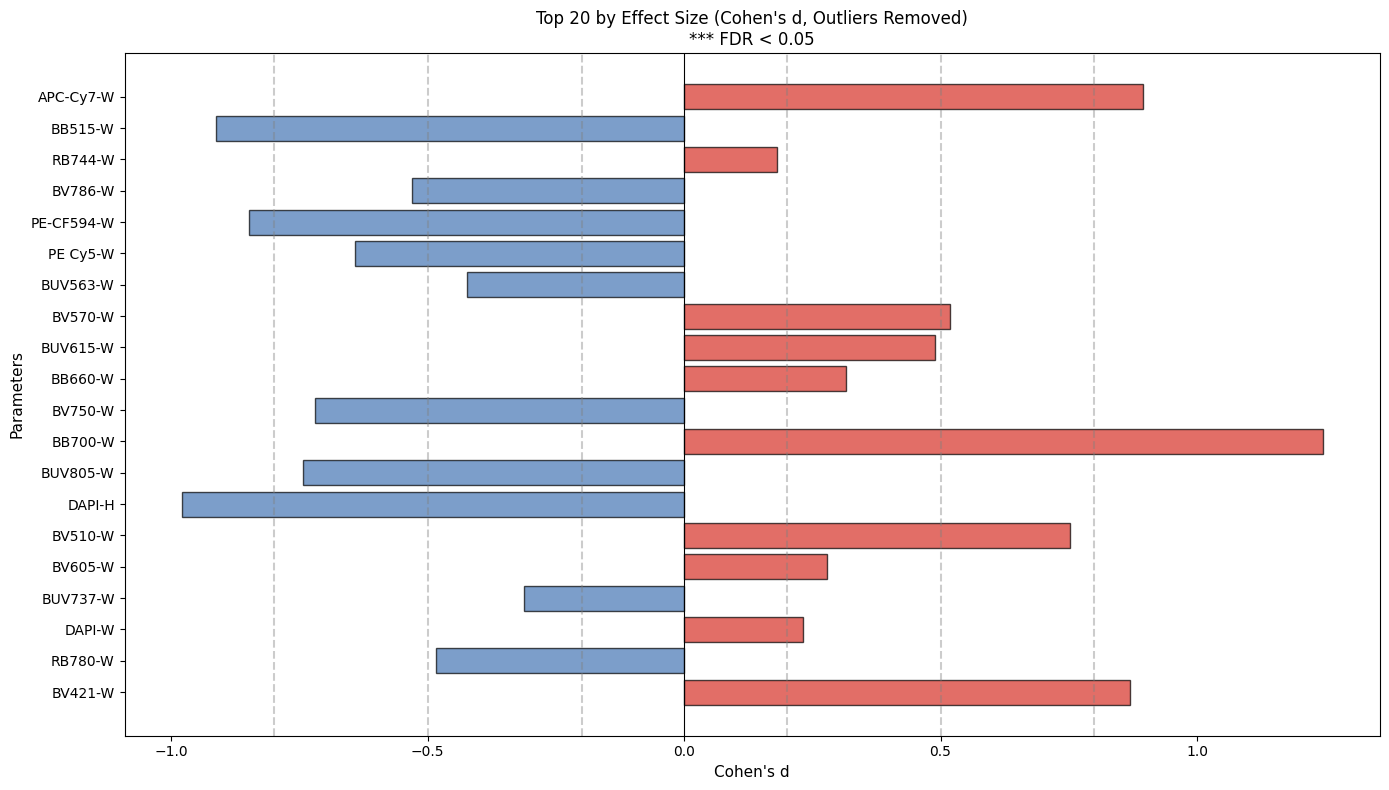

✓ Saved: ./figures/microplastics_differences_cleaned/microplastics_cohens_d_cleaned.png

=== ANALISI MICROPLASTICHE 800nm (OUTLIERS REMOVED, IQR k=1.5) ===
Coppie analizzate: 4
Parametri totali: 97
Parametri con dati validi (n>=2): 97
Parametri significativi (FDR < 0.05): 0
  ⚠ Nessun parametro significativo trovato.

Top 10 parametri per effetto assoluto:
Parameter                      Mean Δ     Cohen d    95% CI                    FDR        N    
-----------------------------------------------------------------------------------------------
APC-Cy7-W                          0.917     0.894 [-0.858, 2.693]              0.9554 4     
BB515-W                           -0.932    -0.913 [-2.700, 0.835]              0.9308 4     
RB744-W                            0.208     0.181 [-1.779, 2.195]              0.9765 4     
BV786-W                           -0.586    -0.530 [-2.496, 1.325]              0.9756 4     
PE-CF594-W                        -0.879    -0.847 [-2.674, 0.916]       

<Figure size 640x480 with 0 Axes>

✓ Saved: ./figures/microplastics_differences_cleaned/microplastics_effect_sizes_cohens_d.png

=== ANALISI EFFETTI MICROPLASTICHE 800nm (con statistiche) ===
Coppie analizzate: 4
Parametri totali: 97
Parametri significativi (FDR < 0.05): 0

Top 10 parametri per effetto assoluto (con statistiche):
Parameter                      Mean Δ     Cohen d    95% CI                    FDR        Dir  
-----------------------------------------------------------------------------------------------
APC-Cy7-W                          0.917     0.894 [-0.858, 2.693]              0.9554 UP    
BB515-W                           -0.932    -0.913 [-2.700, 0.835]              0.9308 DOWN  
RB744-W                            0.208     0.181 [-1.779, 2.195]              0.9765 UP    
BV786-W                           -0.586    -0.530 [-2.496, 1.325]              0.9756 DOWN  
PE-CF594-W                        -0.879    -0.847 [-2.674, 0.916]              0.9192 DOWN  
PE Cy5-W                          -0.695 

In [18]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import t

# Usa i dati già processati senza triton dall'analisi precedente
print("Campioni disponibili (no triton):", ordered_samples)

# Mappatura manuale delle coppie basata sui nomi dei file
control_treatment_pairs = [
    ('02092024_Sangue_topi_Sangue_topo_1', '02092024_Sangue_topi_Sangue_topo_1_800nm'),
    ('02092024_Sangue_topi_Sangue_topo_2', '02092024_Sangue_topi_Sangue_topo_2_800nm'),
    ('02092024_Sangue_topi_Sangue_topo_3', '02092024_Sangue_topi_Sangue_topo_3_800nm'),
    ('02092024_Sangue_topi_Sangue_topo_4', '02092024_Sangue_topi_Sangue_topo_4_800nm')
]

print(f"\nCoppie controllo-trattamento definite:")
valid_pairs = []
for ctrl, treat in control_treatment_pairs:
    if ctrl in ordered_samples and treat in ordered_samples:
        valid_pairs.append((ctrl, treat))
        print(f"  ✓ {ctrl} -> {treat}")
    else:
        missing = []
        if ctrl not in ordered_samples:
            missing.append(f"controllo '{ctrl}'")
        if treat not in ordered_samples:
            missing.append(f"trattamento '{treat}'")
        print(f"  ✗ MANCANTE: {', '.join(missing)}")

if len(valid_pairs) == 0:
    print("ERRORE: Nessuna coppia valida trovata!")
    print("Campioni disponibili:", ordered_samples)
else:
    print(f"\nProcedo con {len(valid_pairs)} coppie valide")
    
    # ========== RIMOZIONE OUTLIER ==========
    
    def remove_outliers_iqr(df, multiplier=1.5):
        """
        Rimuove outlier usando il metodo IQR (Interquartile Range).
        Per ogni parametro (colonna), valori fuori da [Q1 - k*IQR, Q3 + k*IQR] 
        vengono rimossi (impostati a NaN).
        
        multiplier: 1.5 (default) è standard, 3.0 è più conservativo
        """
        df_cleaned = df.copy()
        n_outliers_total = 0
        outlier_info = []
        
        for col in df_cleaned.columns:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            # Identifica outlier
            outliers_mask = (df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)
            n_outliers = outliers_mask.sum()
            
            if n_outliers > 0:
                outlier_info.append({
                    'parameter': col,
                    'n_outliers': n_outliers,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound,
                    'Q1': Q1,
                    'Q3': Q3,
                    'IQR': IQR
                })
                n_outliers_total += n_outliers
                # Rimuovi outlier (imposta a NaN, poi li droppiamo o interpoliamo)
                df_cleaned.loc[outliers_mask, col] = np.nan
        
        return df_cleaned, outlier_info, n_outliers_total
    
    # Applica rimozione outlier ai dati standardizzati delle coppie
    print("\n" + "="*60)
    print("RIMOZIONE OUTLIER (metodo IQR, k=1.5)")
    print("="*60)
    
    # Raccogli tutti i valori standardizzati per controllo e trattamento
    all_controls = []
    all_treatments = []
    
    for control, treatment in valid_pairs:
        all_controls.append(sample_means_ordered_std.loc[control].values)
        all_treatments.append(sample_means_ordered_std.loc[treatment].values)
    
    # Crea DataFrame temporaneo con TUTTE le osservazioni (controlli + trattamenti)
    all_data_list = all_controls + all_treatments
    temp_df = pd.DataFrame(all_data_list, columns=markers)
    
    print(f"Dati totali prima della pulizia: {temp_df.shape[0]} osservazioni x {temp_df.shape[1]} parametri")
    print(f"Valori totali: {temp_df.size}")
    
    # Rimuovi outlier
    temp_df_cleaned, outlier_info, n_outliers = remove_outliers_iqr(temp_df, multiplier=1.5)
    
    print(f"\n✓ Outlier rimossi: {n_outliers} valori ({n_outliers/temp_df.size*100:.2f}% del totale)")
    
    if len(outlier_info) > 0:
        print(f"\nParametri con outlier (top 10 per numero di outlier):")
        outlier_df = pd.DataFrame(outlier_info).sort_values('n_outliers', ascending=False)
        print(f"{'Parameter':<30} {'N outliers':<12} {'IQR':<10} {'Bounds':<30}")
        print("-" * 90)
        for _, row in outlier_df.head(10).iterrows():
            bounds_str = f"[{row['lower_bound']:.2f}, {row['upper_bound']:.2f}]"
            print(f"{row['parameter']:<30} {row['n_outliers']:<12} {row['IQR']:<10.3f} {bounds_str:<30}")
    
    # Ripristina i dati puliti nelle liste separate (controlli e trattamenti)
    n_pairs = len(valid_pairs)
    control_array_cleaned = temp_df_cleaned.iloc[:n_pairs].values
    treatment_array_cleaned = temp_df_cleaned.iloc[n_pairs:].values
    
    # Ora ricalcola le differenze SENZA outlier
    differences_list_cleaned = []
    pair_names = []
    
    for i, (control, treatment) in enumerate(valid_pairs):
        control_data_clean = control_array_cleaned[i]
        treatment_data_clean = treatment_array_cleaned[i]
        
        # Calcola la differenza (effetto delle microplastiche) - NaN se uno dei due è outlier
        difference = treatment_data_clean - control_data_clean
        differences_list_cleaned.append(difference)
        
        # Nome della coppia per il plot
        topo_num = control.split('_topo_')[1].split('_')[0]
        pair_name = f"mouse_{topo_num}_800nm_effect"
        pair_names.append(pair_name)
        
        # Conta quanti valori validi rimangono per questa coppia
        valid_count = np.sum(~np.isnan(difference))
        print(f"Coppia {pair_name}: {valid_count}/{len(markers)} parametri validi dopo pulizia")
    
    # Crea DataFrame delle differenze (ora con possibili NaN dove c'erano outlier)
    differences_df = pd.DataFrame(differences_list_cleaned, columns=markers, index=pair_names)
    
    print(f"\n✓ Matrice differenze (cleaned) shape: {differences_df.shape}")
    print(f"✓ Valori validi: {differences_df.notna().sum().sum()}/{differences_df.size} ({differences_df.notna().sum().sum()/differences_df.size*100:.1f}%)")
    
    # ========== CALCOLO METRICHE STATISTICHE (su dati puliti) ==========
    
    def cohen_d(x, y):
        """Cohen's d effect size: (mean_x - mean_y) / pooled_std"""
        # Rimuovi NaN
        x = x[~np.isnan(x)]
        y = y[~np.isnan(y)]
        nx, ny = len(x), len(y)
        if nx < 2 or ny < 2:
            return np.nan
        dof = nx + ny - 2
        pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)
        if pooled_std == 0:
            return np.nan
        return (np.mean(x) - np.mean(y)) / pooled_std
    
    def confidence_interval_diff(x, y, confidence=0.95):
        """95% CI for difference of means (x - y)"""
        x = x[~np.isnan(x)]
        y = y[~np.isnan(y)]
        nx, ny = len(x), len(y)
        if nx < 2 or ny < 2:
            return np.nan, np.nan
        mean_diff = np.mean(x) - np.mean(y)
        se_diff = np.sqrt(np.var(x, ddof=1)/nx + np.var(y, ddof=1)/ny)
        dof = nx + ny - 2
        t_crit = t.ppf((1 + confidence) / 2, dof)
        margin = t_crit * se_diff
        return mean_diff - margin, mean_diff + margin
    
    def benjamini_hochberg(pvals):
        """Benjamini-Hochberg FDR correction"""
        pvals = np.array(pvals)
        # Remove NaN
        valid_mask = ~np.isnan(pvals)
        if valid_mask.sum() == 0:
            return pvals
        
        n = valid_mask.sum()
        corrected = np.full_like(pvals, np.nan)
        
        valid_pvals = pvals[valid_mask]
        sorted_idx = np.argsort(valid_pvals)
        sorted_pvals = valid_pvals[sorted_idx]
        
        ranks = np.arange(1, n + 1)
        corrected_sorted = sorted_pvals * n / ranks
        corrected_sorted = np.minimum.accumulate(corrected_sorted[::-1])[::-1]
        corrected_sorted = np.clip(corrected_sorted, 0, 1)
        
        original_order = np.argsort(sorted_idx)
        corrected[valid_mask] = corrected_sorted[original_order]
        
        return corrected
    
    # Per ogni parametro, calcola statistiche
    n_params = len(markers)
    effect_sizes = []
    ci_lower = []
    ci_upper = []
    pvals = []
    
    print("\nCalcolo statistiche per ogni parametro (su dati puliti)...")
    for i in range(n_params):
        ctrl_vals = control_array_cleaned[:, i]
        treat_vals = treatment_array_cleaned[:, i]
        
        # Cohen's d
        d = cohen_d(treat_vals, ctrl_vals)
        effect_sizes.append(d)
        
        # 95% CI
        ci_low, ci_high = confidence_interval_diff(treat_vals, ctrl_vals)
        ci_lower.append(ci_low)
        ci_upper.append(ci_high)
        
        # Paired t-test (ignora NaN)
        valid_mask = ~np.isnan(ctrl_vals) & ~np.isnan(treat_vals)
        if valid_mask.sum() >= 2:
            _, p = stats.ttest_rel(treat_vals[valid_mask], ctrl_vals[valid_mask])
            pvals.append(p)
        else:
            pvals.append(np.nan)
    
    # FDR correction
    fdr_corrected = benjamini_hochberg(pvals)
    
    # Crea DataFrame con tutte le statistiche
    stats_df = pd.DataFrame({
        'parameter': markers,
        'mean_difference': np.nanmean(differences_df.values, axis=0),
        'std_difference': np.nanstd(differences_df.values, axis=0),
        'cohen_d': effect_sizes,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': pvals,
        'fdr_corrected': fdr_corrected,
        'abs_mean_effect': np.nanmean(np.abs(differences_df.values), axis=0),
        'n_valid': differences_df.notna().sum(axis=0).values
    })
    
    # Significatività (FDR < 0.05)
    stats_df['significant_fdr'] = stats_df['fdr_corrected'] < 0.05
    
    # Classifica effetto (up/down)
    stats_df['direction'] = stats_df['mean_difference'].apply(lambda x: 'UP' if x > 0 else 'DOWN')
    
    # Ordina per effetto assoluto
    stats_df = stats_df.sort_values('abs_mean_effect', ascending=False).reset_index(drop=True)
    
    print(f"\n✓ Statistiche calcolate per {n_params} parametri")
    print(f"✓ Parametri con dati sufficienti (n>=2): {(stats_df['n_valid'] >= 2).sum()}")
    print(f"✓ Parametri significativi (FDR < 0.05): {stats_df['significant_fdr'].sum()}")
    
    # ========== VISUALIZZAZIONI ==========
    
    out_dir = "./figures/microplastics_differences_cleaned"
    os.makedirs(out_dir, exist_ok=True)
    
    # Plot 1: Heatmap completa delle differenze (dati puliti)
    fig, ax = plt.subplots(1, 1, figsize=(25, 8))
    vmax = np.nanmax(np.abs(differences_df.values))
    vmin = -vmax
    
    sns.heatmap(differences_df, ax=ax, cmap='RdBu_r', center=0, vmin=vmin, vmax=vmax,
                cbar_kws={'label': 'Difference (800nm - control) [z-score, outliers removed]'}, 
                linewidths=0.5, annot=False, mask=differences_df.isna())
    ax.set_title("Microplastics Effect: 800nm - Control (Outliers Removed)", fontsize=18)
    ax.set_xlabel("Flow Cytometry Parameters", fontsize=18)
    ax.set_ylabel("Sample Pairs (Topi)", fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.tight_layout()
    
    out_path = os.path.join(out_dir, "microplastics_differences_all_params_cleaned.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {out_path}")
    
    # Plot 2: Barplot con effetti e CI (top 20, solo con n_valid >= 2)
    valid_stats = stats_df[stats_df['n_valid'] >= 2]
    top_20_stats = valid_stats.head(20)
    
    if len(top_20_stats) > 0:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        x_pos = np.arange(len(top_20_stats))
        colors = ['#d73027' if d == 'UP' else '#4575b4' for d in top_20_stats['direction']]
        
        bars = ax.bar(x_pos, top_20_stats['mean_difference'].values, 
                       color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Add CI as error bars
        yerr_lower = top_20_stats['mean_difference'].values - top_20_stats['ci_lower'].values
        yerr_upper = top_20_stats['ci_upper'].values - top_20_stats['mean_difference'].values
        ax.errorbar(x_pos, top_20_stats['mean_difference'].values,
                    yerr=[yerr_lower, yerr_upper],
                    fmt='none', ecolor='black', capsize=3, capthick=1.5, alpha=0.6)
        
        # Mark significant bars
        for i, (idx, row) in enumerate(top_20_stats.iterrows()):
            if row['significant_fdr']:
                y_pos = row['mean_difference'] + (row['ci_upper'] - row['mean_difference']) * 1.15
                ax.text(i, y_pos, '***', ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax.axhline(0, color='black', linewidth=0.8, linestyle='-')
        ax.set_title("Top 20 Parameters (Outliers Removed)\nwith 95% CI and FDR significance", fontsize=18)
        ax.set_xlabel("Parameters", fontsize=18)
        ax.set_ylabel("Mean Effect [z-score]", fontsize=18)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(top_20_stats['parameter'].values, rotation=45, ha='right', fontsize=15)
        
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#d73027', alpha=0.7, label='Increased'),
            Patch(facecolor='#4575b4', alpha=0.7, label='Decreased'),
            Patch(facecolor='white', edgecolor='black', label='*** FDR < 0.05')
        ]
        ax.legend(handles=legend_elements, loc='best')
        
        plt.tight_layout()
        out_path = os.path.join(out_dir, "microplastics_top_effects_cleaned.png")
        fig.savefig(out_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved: {out_path}")
    
    # Plot 3: Effect size (Cohen's d)
    if len(valid_stats) > 0:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        top_20_d = valid_stats.nlargest(20, 'abs_mean_effect')
        y_pos = np.arange(len(top_20_d))
        colors_d = ['#d73027' if d == 'UP' else '#4575b4' for d in top_20_d['direction']]
        
        bars = ax.barh(y_pos, top_20_d['cohen_d'].values, color=colors_d, alpha=0.7, edgecolor='black')
        
        # Mark significant
        for i, (idx, row) in enumerate(top_20_d.iterrows()):
            if row['significant_fdr']:
                x_pos_mark = row['cohen_d'] * 1.08 if row['cohen_d'] > 0 else row['cohen_d'] * 0.92
                ax.text(x_pos_mark, i, '***', ha='left' if row['cohen_d'] > 0 else 'right', 
                        va='center', fontsize=10, fontweight='bold')
        
        ax.axvline(0, color='black', linewidth=0.8)
        for thresh in [0.2, 0.5, 0.8]:
            ax.axvline(thresh, color='gray', linestyle='--', alpha=0.4)
            ax.axvline(-thresh, color='gray', linestyle='--', alpha=0.4)
        
        ax.set_title("Top 20 by Effect Size (Cohen's d, Outliers Removed)\n*** FDR < 0.05", fontsize=12)
        ax.set_xlabel("Cohen's d", fontsize=11)
        ax.set_ylabel("Parameters", fontsize=11)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_20_d['parameter'].values)
        ax.invert_yaxis()
        
        plt.tight_layout()
        out_path = os.path.join(out_dir, "microplastics_cohens_d_cleaned.png")
        fig.savefig(out_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved: {out_path}")
    
    # ========== STATISTICHE RIASSUNTIVE ==========
    
    print(f"\n{'='*70}")
    print(f"=== ANALISI MICROPLASTICHE 800nm (OUTLIERS REMOVED, IQR k=1.5) ===")
    print(f"{'='*70}")
    print(f"Coppie analizzate: {len(valid_pairs)}")
    print(f"Parametri totali: {len(markers)}")
    print(f"Parametri con dati validi (n>=2): {(stats_df['n_valid'] >= 2).sum()}")
    print(f"Parametri significativi (FDR < 0.05): {stats_df['significant_fdr'].sum()}")
    
    sig_stats = stats_df[stats_df['significant_fdr']]
    if len(sig_stats) > 0:
        print(f"  ✓ UP-regulated (significant): {(sig_stats['direction'] == 'UP').sum()}")
        print(f"  ✓ DOWN-regulated (significant): {(sig_stats['direction'] == 'DOWN').sum()}")
        
        print(f"\nParametri SIGNIFICATIVI (FDR < 0.05):")
        print(f"{'Parameter':<30} {'Mean Δ':<10} {'Cohen d':<10} {'95% CI':<25} {'FDR':<10} {'N':<5}")
        print("-" * 95)
        for _, row in sig_stats.iterrows():
            ci_str = f"[{row['ci_lower']:.3f}, {row['ci_upper']:.3f}]"
            print(f"{row['parameter']:<30} {row['mean_difference']:>9.3f} {row['cohen_d']:>9.3f} "
                  f"{ci_str:<25} {row['fdr_corrected']:>9.4f} {int(row['n_valid']):<5}")
    else:
        print("  ⚠ Nessun parametro significativo trovato.")
    
    print(f"\nTop 10 parametri per effetto assoluto:")
    print(f"{'Parameter':<30} {'Mean Δ':<10} {'Cohen d':<10} {'95% CI':<25} {'FDR':<10} {'N':<5}")
    print("-" * 95)
    for _, row in stats_df.head(10).iterrows():
        ci_str = f"[{row['ci_lower']:.3f}, {row['ci_upper']:.3f}]"
        sig_mark = "***" if row['significant_fdr'] else ""
        print(f"{row['parameter']:<30} {row['mean_difference']:>9.3f} {row['cohen_d']:>9.3f} "
              f"{ci_str:<25} {row['fdr_corrected']:>9.4f} {int(row['n_valid']):<5} {sig_mark}")
    
    # Export
    csv_path = os.path.join(out_dir, "microplastics_800nm_differences_cleaned.csv")
    differences_df.to_csv(csv_path)
    print(f"\n✓ Differenze (cleaned) esportate in: {csv_path}")
    
    stats_path = os.path.join(out_dir, "microplastics_800nm_statistics_cleaned.csv")
    stats_df.to_csv(stats_path, index=False, float_format="%.6f")
    print(f"✓ Statistiche complete esportate in: {stats_path}")
    
    if len(sig_stats) > 0:
        sig_path = os.path.join(out_dir, "microplastics_800nm_significant_cleaned.csv")
        sig_stats.to_csv(sig_path, index=False, float_format="%.6f")
        print(f"✓ Parametri significativi esportati in: {sig_path}")
    
    # Export info outlier
    if len(outlier_info) > 0:
        outlier_path = os.path.join(out_dir, "outliers_removed_info.csv")
        pd.DataFrame(outlier_info).to_csv(outlier_path, index=False)
        print(f"✓ Info outlier rimossi esportati in: {outlier_path}")
    
    print(f"\n🎯 Analisi completata con rimozione outlier!")
    print(f"📊 Metodo: IQR con k=1.5 (outliers fuori da [Q1-1.5*IQR, Q3+1.5*IQR])")
    print(f"📁 Risultati salvati in: {out_dir}")
    ax.axvline(0, color='black', linewidth=0.8)
    # Effect size thresholds (Cohen: small=0.2, medium=0.5, large=0.8)
    for thresh, label in [(0.2, 'small'), (0.5, 'medium'), (0.8, 'large')]:
        ax.axvline(thresh, color='gray', linestyle='--', alpha=0.4)
        ax.axvline(-thresh, color='gray', linestyle='--', alpha=0.4)
    
    ax.set_title("Top 20 Parameters by Effect Size (Cohen's d)\n(*** FDR < 0.05)", fontsize=12)
    ax.set_xlabel("Cohen's d (Effect Size)", fontsize=11)
    ax.set_ylabel("Parameters", fontsize=11)
    ax.set_yticks(x_pos)
    ax.set_yticklabels(top_20_d['parameter'].values)
    ax.invert_yaxis()
    
    plt.tight_layout()
    out_path = os.path.join(out_dir, "microplastics_effect_sizes_cohens_d.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {out_path}")
    
    # ========== STATISTICHE RIASSUNTIVE ==========
    
    print(f"\n{'='*60}")
    print(f"=== ANALISI EFFETTI MICROPLASTICHE 800nm (con statistiche) ===")
    print(f"{'='*60}")
    print(f"Coppie analizzate: {len(valid_pairs)}")
    print(f"Parametri totali: {len(markers)}")
    print(f"Parametri significativi (FDR < 0.05): {stats_df['significant_fdr'].sum()}")
    
    sig_stats = stats_df[stats_df['significant_fdr']]
    if len(sig_stats) > 0:
        print(f"  - UP-regulated (significant): {(sig_stats['direction'] == 'UP').sum()}")
        print(f"  - DOWN-regulated (significant): {(sig_stats['direction'] == 'DOWN').sum()}")
    
    print(f"\nTop 10 parametri per effetto assoluto (con statistiche):")
    print(f"{'Parameter':<30} {'Mean Δ':<10} {'Cohen d':<10} {'95% CI':<25} {'FDR':<10} {'Dir':<5}")
    print("-" * 95)
    for _, row in stats_df.head(10).iterrows():
        ci_str = f"[{row['ci_lower']:.3f}, {row['ci_upper']:.3f}]"
        sig_mark = "***" if row['significant_fdr'] else ""
        print(f"{row['parameter']:<30} {row['mean_difference']:>9.3f} {row['cohen_d']:>9.3f} {ci_str:<25} "
              f"{row['fdr_corrected']:>9.4f} {row['direction']:<5} {sig_mark}")
    
    # Export dati
    csv_path = os.path.join(out_dir, "microplastics_800nm_differences.csv")
    differences_df.to_csv(csv_path)
    print(f"\n✓ Differenze esportate in: {csv_path}")
    
    # Export statistiche complete
    stats_path = os.path.join(out_dir, "microplastics_800nm_statistics.csv")
    stats_df.to_csv(stats_path, index=False, float_format="%.6f")
    print(f"✓ Statistiche complete esportate in: {stats_path}")
    
    # Export solo parametri significativi
    if len(sig_stats) > 0:
        sig_path = os.path.join(out_dir, "microplastics_800nm_significant_only.csv")
        sig_stats.to_csv(sig_path, index=False, float_format="%.6f")
        print(f"✓ Parametri significativi (FDR<0.05) esportati in: {sig_path}")
    
    print(f"\n🎯 Analisi completata!")
    print("📊 Interpretazione:")
    print("   - Cohen's d: |d| < 0.2 (piccolo), 0.2-0.5 (medio), > 0.8 (grande)")
    print("   - 95% CI: intervallo di confidenza della differenza media")
    print("   - FDR: probabilità corretta di falso positivo (*** se < 0.05)")
    print("   - Rosso = UP-regulated, Blu = DOWN-regulated")


CREAZIONE HEATMAP SEPARATE PER DIREZIONE EFFETTO

Parametri UP-regulated (media > 0): 57
Parametri DOWN-regulated (media < 0): 40


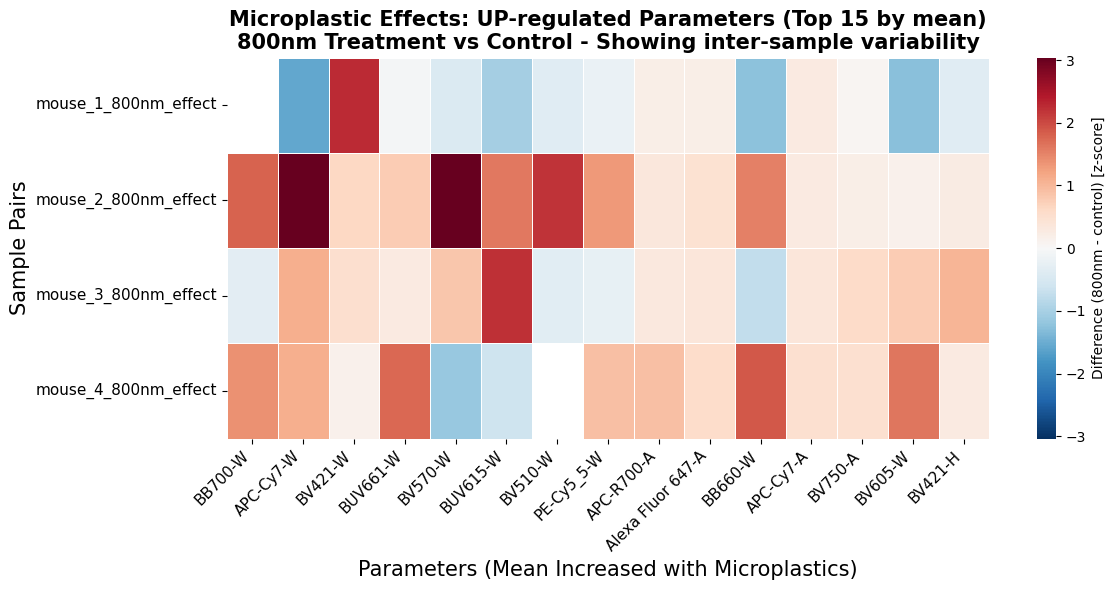


✓ Heatmap UP-regulated salvata: ./figures/microplastics_differences_cleaned/heatmap_UP_regulated_top15.png
  Range colori: -3.040 to 3.040 (simmetrico, mostra variabilità)

  Consistenza direzione effetto (su 4 campioni):
    BB700-W                       : 2/4 campioni UP (50%), mean=+0.953
    APC-Cy7-W                     : 3/4 campioni UP (75%), mean=+0.917
    BV421-W                       : 4/4 campioni UP (100%), mean=+0.897
    BUV661-W                      : 3/4 campioni UP (75%), mean=+0.684
    BV570-W                       : 2/4 campioni UP (50%), mean=+0.574
    BUV615-W                      : 2/4 campioni UP (50%), mean=+0.544
    BV510-W                       : 1/4 campioni UP (25%), mean=+0.499
    PE-Cy5_5-W                    : 2/4 campioni UP (50%), mean=+0.449
    APC-R700-A                    : 4/4 campioni UP (100%), mean=+0.447
    Alexa Fluor 647-A             : 4/4 campioni UP (100%), mean=+0.397

Top 10 UP-regulated parameters (mean z-score difference):
   1.

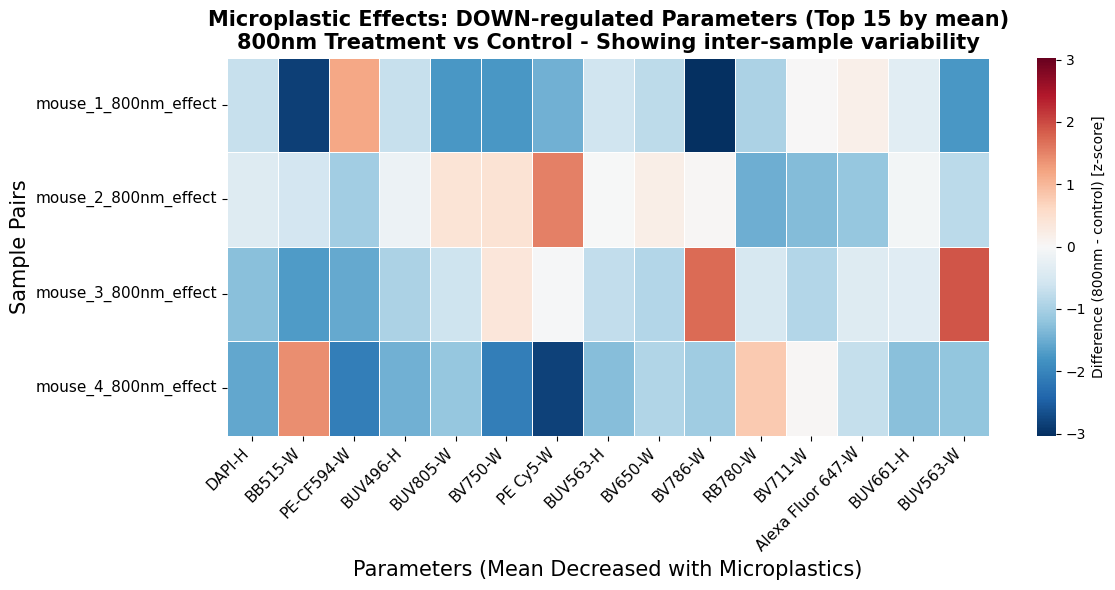


✓ Heatmap DOWN-regulated salvata: ./figures/microplastics_differences_cleaned/heatmap_DOWN_regulated_top15.png
  Range colori: -3.032 to 3.032 (simmetrico, mostra variabilità)

  Consistenza direzione effetto (su 4 campioni):
    DAPI-H                        : 4/4 campioni DOWN (100%), mean=-0.985
    BB515-W                       : 3/4 campioni DOWN (75%), mean=-0.932
    PE-CF594-W                    : 3/4 campioni DOWN (75%), mean=-0.879
    BUV496-H                      : 4/4 campioni DOWN (100%), mean=-0.830
    BUV805-W                      : 3/4 campioni DOWN (75%), mean=-0.789
    BV750-W                       : 2/4 campioni DOWN (50%), mean=-0.768
    PE Cy5-W                      : 3/4 campioni DOWN (75%), mean=-0.695
    BUV563-H                      : 4/4 campioni DOWN (100%), mean=-0.665
    BV650-W                       : 3/4 campioni DOWN (75%), mean=-0.598
    BV786-W                       : 2/4 campioni DOWN (50%), mean=-0.586

Top 10 DOWN-regulated parameters (mean 

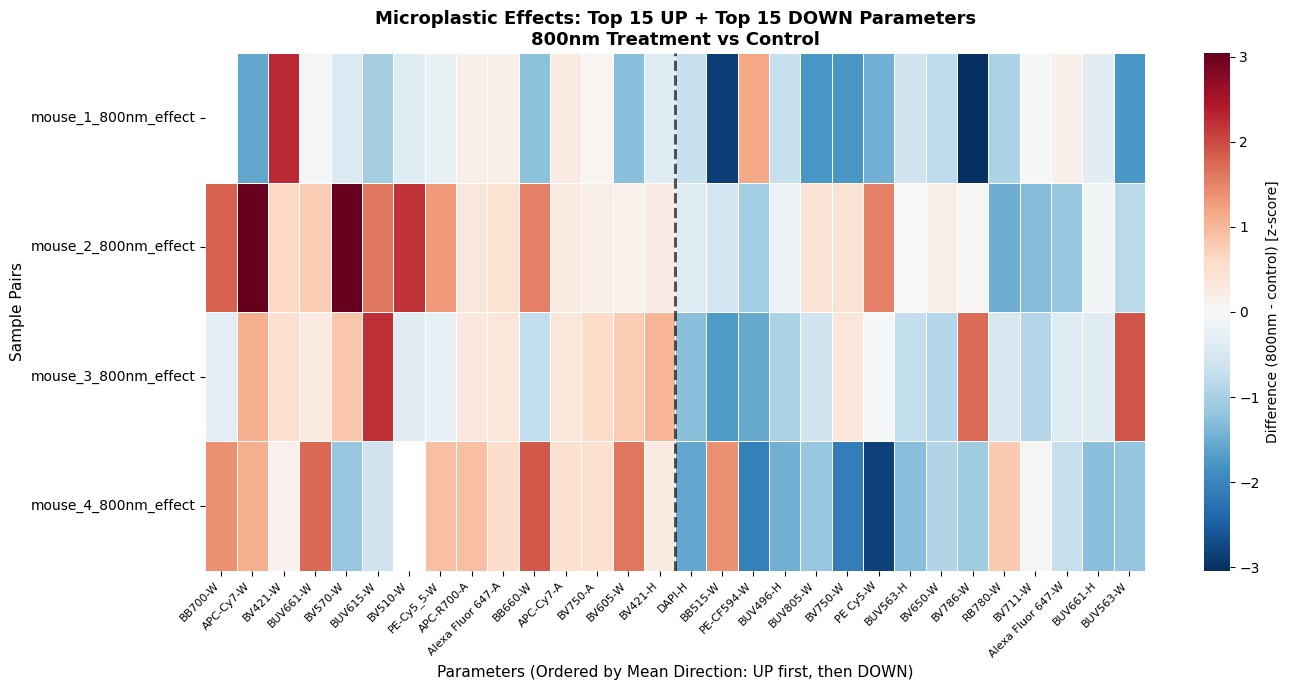


✓ Heatmap combinata UP+DOWN salvata: ./figures/microplastics_differences_cleaned/heatmap_COMBINED_top15_each_direction.png
  Range colori: -3.040 to +3.040 (simmetrico)

✓ Heatmap per direzione completate!
📁 File salvati in: ./figures/microplastics_differences_cleaned

📊 Note sulla visualizzazione:
  • Tutte le heatmap usano scala divergente RdBu_r (rosso=UP, blu=DOWN)
  • I parametri sono selezionati in base alla MEDIA della direzione dell'effetto
  • La variabilità inter-campione è visibile (alcuni campioni possono variare)
  • Blu in heatmap 'UP-regulated' indica campioni con effetto opposto alla media
  • La consistenza della direzione è stampata nel report sopra


In [19]:
# ========== HEATMAP SEPARATE PER DIREZIONE (UP vs DOWN) ==========

print(f"\n{'='*80}")
print("CREAZIONE HEATMAP SEPARATE PER DIREZIONE EFFETTO")
print("="*80)

# Calcola la media delle differenze per ogni parametro
param_means = differences_df.mean(axis=0)

# Separa parametri UP (media positiva) e DOWN (media negativa)
up_params = param_means[param_means > 0].sort_values(ascending=False)
down_params = param_means[param_means < 0].sort_values(ascending=True)

print(f"\nParametri UP-regulated (media > 0): {len(up_params)}")
print(f"Parametri DOWN-regulated (media < 0): {len(down_params)}")

# Crea directory output se non esiste
out_dir_heatmaps = "./figures/microplastics_differences_cleaned"
os.makedirs(out_dir_heatmaps, exist_ok=True)

# ========== HEATMAP PARAMETRI UP-REGULATED (con scala divergente) ==========
if len(up_params) > 0:
    # Prendi tutti i parametri UP (o top 20 se troppi)
    n_up = min(15, len(up_params))
    top_up_params = up_params.head(n_up)
    
    # Subset del DataFrame differenze
    up_diff = differences_df[top_up_params.index]
    
    # Calcola range SIMMETRICO per mostrare sia up che down in ogni parametro
    # Questo permette di vedere la variabilità tra campioni
    vmax_up = max(abs(np.nanmin(up_diff.values)), abs(np.nanmax(up_diff.values)))
    vmin_up = -vmax_up
    
    # Plot con colormap DIVERGENTE (RdBu_r)
    fig, ax = plt.subplots(1, 1, figsize=(max(12, n_up*0.4), 6))
    sns.heatmap(up_diff, ax=ax, cmap='RdBu_r', center=0, vmin=vmin_up, vmax=vmax_up,
                cbar_kws={'label': 'Difference (800nm - control) [z-score]'}, 
                linewidths=0.5, annot=False, mask=up_diff.isna())
    ax.set_title(f"Microplastic Effects: UP-regulated Parameters (Top {n_up} by mean)\n"
                 f"800nm Treatment vs Control - Showing inter-sample variability", 
                 fontsize=15, fontweight='bold')
    ax.set_xlabel("Parameters (Mean Increased with Microplastics)", fontsize=15)
    ax.set_ylabel("Sample Pairs", fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
    
    out_path = os.path.join(out_dir_heatmaps, f"heatmap_UP_regulated_top{n_up}.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Heatmap UP-regulated salvata: {out_path}")
    print(f"  Range colori: {vmin_up:.3f} to {vmax_up:.3f} (simmetrico, mostra variabilità)")
    
    # Analizza variabilità inter-campione
    n_positive_per_param = (up_diff > 0).sum(axis=0)
    print(f"\n  Consistenza direzione effetto (su {len(differences_df)} campioni):")
    for param in top_up_params.head(10).index:
        n_pos = n_positive_per_param[param]
        consistency = n_pos / len(differences_df) * 100
        mean_val = up_diff[param].mean()
        print(f"    {param:<30s}: {n_pos}/{len(differences_df)} campioni UP ({consistency:.0f}%), mean={mean_val:+.3f}")
    
    # Stampa top 10
    print(f"\nTop 10 UP-regulated parameters (mean z-score difference):")
    for i, (param, mean_diff) in enumerate(up_params.head(10).items(), 1):
        # Trova statistiche corrispondenti
        param_stats = stats_df[stats_df['parameter'] == param].iloc[0]
        print(f"  {i:2d}. {param:<30s}  Δ={mean_diff:+.3f}  d={param_stats['cohen_d']:+.3f}  p={param_stats['p_value']:.4f}")

# ========== HEATMAP PARAMETRI DOWN-REGULATED (con scala divergente) ==========
if len(down_params) > 0:
    # Prendi tutti i parametri DOWN (o top 30 se troppi)
    n_down = min(15, len(down_params))
    top_down_params = down_params.head(n_down)
    
    # Subset del DataFrame differenze
    down_diff = differences_df[top_down_params.index]
    
    # Calcola range SIMMETRICO per mostrare sia up che down in ogni parametro
    vmax_down = max(abs(np.nanmin(down_diff.values)), abs(np.nanmax(down_diff.values)))
    vmin_down = -vmax_down
    
    # Plot con colormap DIVERGENTE (RdBu_r)
    fig, ax = plt.subplots(1, 1, figsize=(max(12, n_down*0.4), 6))
    sns.heatmap(down_diff, ax=ax, cmap='RdBu_r', center=0, vmin=vmin_down, vmax=vmax_down,
                cbar_kws={'label': 'Difference (800nm - control) [z-score]'}, 
                linewidths=0.5, annot=False, mask=down_diff.isna())
    ax.set_title(f"Microplastic Effects: DOWN-regulated Parameters (Top {n_down} by mean)\n"
                 f"800nm Treatment vs Control - Showing inter-sample variability", 
                 fontsize=15, fontweight='bold')
    ax.set_xlabel("Parameters (Mean Decreased with Microplastics)", fontsize=15)
    ax.set_ylabel("Sample Pairs", fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
    
    out_path = os.path.join(out_dir_heatmaps, f"heatmap_DOWN_regulated_top{n_down}.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Heatmap DOWN-regulated salvata: {out_path}")
    print(f"  Range colori: {vmin_down:.3f} to {vmax_down:.3f} (simmetrico, mostra variabilità)")
    
    # Analizza variabilità inter-campione
    n_negative_per_param = (down_diff < 0).sum(axis=0)
    print(f"\n  Consistenza direzione effetto (su {len(differences_df)} campioni):")
    for param in top_down_params.head(10).index:
        n_neg = n_negative_per_param[param]
        consistency = n_neg / len(differences_df) * 100
        mean_val = down_diff[param].mean()
        print(f"    {param:<30s}: {n_neg}/{len(differences_df)} campioni DOWN ({consistency:.0f}%), mean={mean_val:+.3f}")
    
    # Stampa top 10
    print(f"\nTop 10 DOWN-regulated parameters (mean z-score difference):")
    for i, (param, mean_diff) in enumerate(down_params.head(10).items(), 1):
        # Trova statistiche corrispondenti
        param_stats = stats_df[stats_df['parameter'] == param].iloc[0]
        print(f"  {i:2d}. {param:<30s}  Δ={mean_diff:+.3f}  d={param_stats['cohen_d']:+.3f}  p={param_stats['p_value']:.4f}")

# ========== HEATMAP COMBINATA (UP sopra, DOWN sotto) ==========
if len(up_params) > 0 and len(down_params) > 0:
    # Prendi top 15 per ciascuna direzione
    n_each = 15
    top15_up = up_params.head(n_each)
    top15_down = down_params.head(n_each)
    
    # Combina
    combined_params = pd.concat([top15_up, top15_down])
    combined_diff = differences_df[combined_params.index]
    
    # Plot con colormap divergente centrato su 0
    vmax_combined = max(abs(np.nanmin(combined_diff.values)), abs(np.nanmax(combined_diff.values)))
    
    fig, ax = plt.subplots(1, 1, figsize=(max(14, len(combined_params)*0.35), 7))
    sns.heatmap(combined_diff, ax=ax, cmap='RdBu_r', center=0, 
                vmin=-vmax_combined, vmax=vmax_combined,
                cbar_kws={'label': 'Difference (800nm - control) [z-score]'}, 
                linewidths=0.5, annot=False, mask=combined_diff.isna())
    ax.set_title(f"Microplastic Effects: Top {n_each} UP + Top {n_each} DOWN Parameters\n800nm Treatment vs Control", 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel("Parameters (Ordered by Mean Direction: UP first, then DOWN)", fontsize=11)
    ax.set_ylabel("Sample Pairs", fontsize=11)
    
    # Aggiungi linea divisoria tra UP e DOWN
    ax.axvline(x=len(top15_up), color='black', linewidth=2, linestyle='--', alpha=0.7)
    
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    
    out_path = os.path.join(out_dir_heatmaps, f"heatmap_COMBINED_top{n_each}_each_direction.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Heatmap combinata UP+DOWN salvata: {out_path}")
    print(f"  Range colori: -{vmax_combined:.3f} to +{vmax_combined:.3f} (simmetrico)")

print(f"\n{'='*80}")
print("✓ Heatmap per direzione completate!")
print(f"📁 File salvati in: {out_dir_heatmaps}")
print(f"\n📊 Note sulla visualizzazione:")
print(f"  • Tutte le heatmap usano scala divergente RdBu_r (rosso=UP, blu=DOWN)")
print(f"  • I parametri sono selezionati in base alla MEDIA della direzione dell'effetto")
print(f"  • La variabilità inter-campione è visibile (alcuni campioni possono variare)")
print(f"  • Blu in heatmap 'UP-regulated' indica campioni con effetto opposto alla media")
print(f"  • La consistenza della direzione è stampata nel report sopra")


CREAZIONE HEATMAP CON PARAMETRI 100% CONSISTENTI NELLA DIREZIONE

Parametri con 100% consistenza UP (tutti i 4 campioni >0): 7
Parametri con 100% consistenza DOWN (tutti i 4 campioni <0): 5


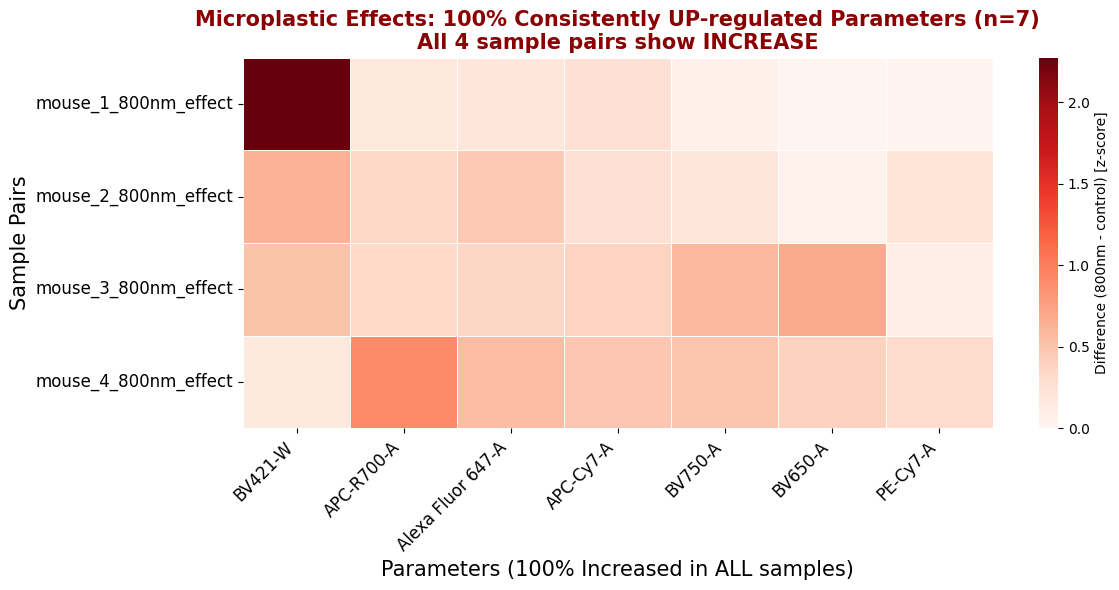


✓ Heatmap 100% UP-regulated salvata: ./figures/microplastics_differences_cleaned/heatmap_100pct_UP_regulated.png
  Range colori: 0.000 to 2.276 (solo valori positivi)

Parametri 100% UP-regulated (ordinati per mean difference):
#    Parameter                      Mean Δ     Min Δ      Max Δ      Cohen d   
------------------------------------------------------------------------------------------
1    BV421-W                            0.897     0.165     2.276     0.869
2    APC-R700-A                         0.447     0.196     0.910     0.397
3    Alexa Fluor 647-A                  0.397     0.207     0.556     0.351
4    APC-Cy7-A                          0.353     0.268     0.489     0.310
5    BV750-A                            0.341     0.066     0.587     0.299
6    BV650-A                            0.282     0.002     0.687     0.247
7    PE-Cy7-A                           0.168     0.018     0.320     0.146


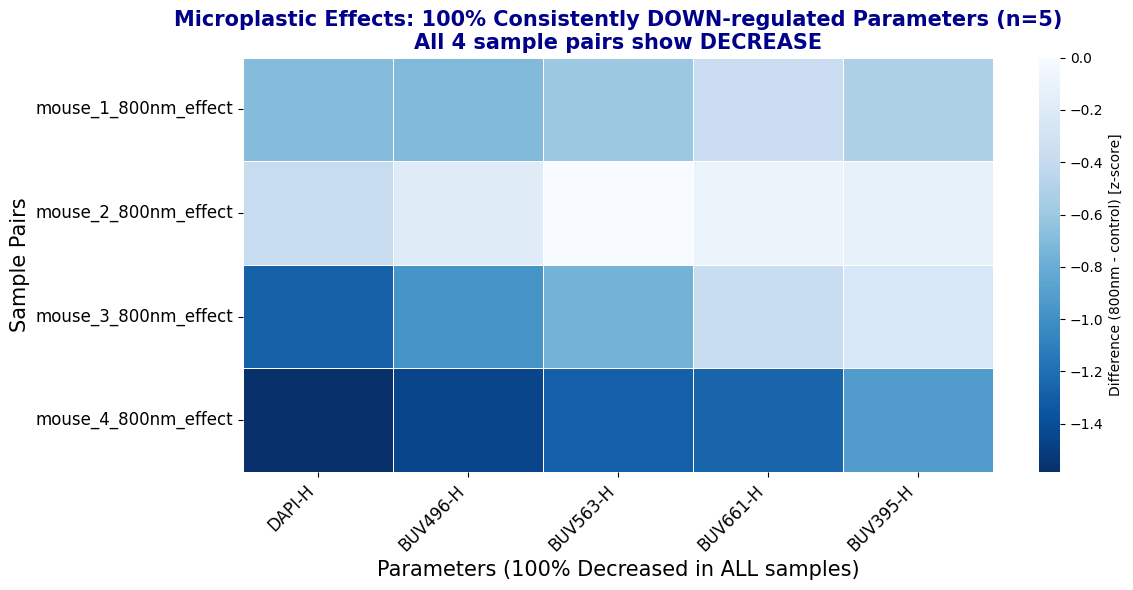


✓ Heatmap 100% DOWN-regulated salvata: ./figures/microplastics_differences_cleaned/heatmap_100pct_DOWN_regulated.png
  Range colori: -1.584 to 0.000 (solo valori negativi)

Parametri 100% DOWN-regulated (ordinati per mean difference):
#    Parameter                      Mean Δ     Min Δ      Max Δ      Cohen d   
------------------------------------------------------------------------------------------
1    DAPI-H                            -0.985    -1.584    -0.385    -0.980
2    BUV496-H                          -0.830    -1.456    -0.187    -0.790
3    BUV563-H                          -0.665    -1.291    -0.006    -0.610
4    BUV661-H                          -0.520    -1.260    -0.092    -0.466
5    BUV395-H                          -0.454    -0.920    -0.126    -0.404

RIASSUNTO CONSISTENZA PARAMETRI:
Parametri totali analizzati: 97
Parametri 100% UP (tutti campioni >0): 7 (7.2%)
Parametri 100% DOWN (tutti campioni <0): 5 (5.2%)
Parametri con consistenza parziale: 85 (87.6%)

D

In [20]:
# ========== HEATMAP CON 100% CONSISTENZA NELLA DIREZIONE ==========

print(f"\n{'='*80}")
print("CREAZIONE HEATMAP CON PARAMETRI 100% CONSISTENTI NELLA DIREZIONE")
print("="*80)

# Per ogni parametro, conta quanti campioni sono UP (>0) e quanti DOWN (<0)
n_samples = len(differences_df)
consistency_analysis = []

for param in differences_df.columns:
    param_values = differences_df[param].dropna()  # Rimuovi NaN
    n_valid = len(param_values)
    
    if n_valid > 0:
        n_positive = (param_values > 0).sum()
        n_negative = (param_values < 0).sum()
        mean_val = param_values.mean()
        
        # Determina se è 100% consistente
        is_100_up = (n_positive == n_valid) and (n_negative == 0)
        is_100_down = (n_negative == n_valid) and (n_positive == 0)
        
        consistency_analysis.append({
            'parameter': param,
            'n_valid': n_valid,
            'n_positive': n_positive,
            'n_negative': n_negative,
            'mean_diff': mean_val,
            'consistency_pct': max(n_positive, n_negative) / n_valid * 100,
            'is_100_up': is_100_up,
            'is_100_down': is_100_down,
            'direction': 'UP' if mean_val > 0 else 'DOWN'
        })

consistency_df = pd.DataFrame(consistency_analysis)

# Filtra parametri 100% consistenti
params_100_up = consistency_df[consistency_df['is_100_up']].sort_values('mean_diff', ascending=False)
params_100_down = consistency_df[consistency_df['is_100_down']].sort_values('mean_diff', ascending=True)

print(f"\nParametri con 100% consistenza UP (tutti i {n_samples} campioni >0): {len(params_100_up)}")
print(f"Parametri con 100% consistenza DOWN (tutti i {n_samples} campioni <0): {len(params_100_down)}")

# Crea directory output
out_dir_consistent = "./figures/microplastics_differences_cleaned"
os.makedirs(out_dir_consistent, exist_ok=True)

# ========== HEATMAP PARAMETRI 100% UP-REGULATED ==========
if len(params_100_up) > 0:
    n_up_100 = min(30, len(params_100_up))
    top_100_up = params_100_up.head(n_up_100)
    
    # Subset del DataFrame differenze
    up_100_diff = differences_df[top_100_up['parameter'].values]
    
    # Usa scala da 0 (tutti valori positivi)
    vmin_up_100 = 0
    vmax_up_100 = np.nanmax(up_100_diff.values)
    
    # Plot con colormap Reds (solo tonalità rosse, NO blu)
    fig, ax = plt.subplots(1, 1, figsize=(max(12, n_up_100*0.4), 6))
    sns.heatmap(up_100_diff, ax=ax, cmap='Reds', vmin=vmin_up_100, vmax=vmax_up_100,
                cbar_kws={'label': 'Difference (800nm - control) [z-score]'}, 
                linewidths=0.5, annot=False, mask=up_100_diff.isna())
    ax.set_title(f"Microplastic Effects: 100% Consistently UP-regulated Parameters (n={n_up_100})\n"
                 f"All {n_samples} sample pairs show INCREASE", 
                 fontsize=15, fontweight='bold', color='darkred')
    ax.set_xlabel("Parameters (100% Increased in ALL samples)", fontsize=15)
    ax.set_ylabel("Sample Pairs", fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    
    out_path = os.path.join(out_dir_consistent, f"heatmap_100pct_UP_regulated.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Heatmap 100% UP-regulated salvata: {out_path}")
    print(f"  Range colori: {vmin_up_100:.3f} to {vmax_up_100:.3f} (solo valori positivi)")
    
    # Stampa tutti i parametri 100% UP
    print(f"\nParametri 100% UP-regulated (ordinati per mean difference):")
    print(f"{'#':<4} {'Parameter':<30} {'Mean Δ':<10} {'Min Δ':<10} {'Max Δ':<10} {'Cohen d':<10}")
    print("-" * 90)
    for i, (idx, row) in enumerate(top_100_up.iterrows(), 1):
        param = row['parameter']
        param_vals = up_100_diff[param].dropna()
        param_stats = stats_df[stats_df['parameter'] == param].iloc[0]
        print(f"{i:<4} {param:<30} {row['mean_diff']:>9.3f} {param_vals.min():>9.3f} "
              f"{param_vals.max():>9.3f} {param_stats['cohen_d']:>9.3f}")

# ========== HEATMAP PARAMETRI 100% DOWN-REGULATED ==========
if len(params_100_down) > 0:
    n_down_100 = min(30, len(params_100_down))
    top_100_down = params_100_down.head(n_down_100)
    
    # Subset del DataFrame differenze
    down_100_diff = differences_df[top_100_down['parameter'].values]
    
    # Usa scala fino a 0 (tutti valori negativi)
    vmin_down_100 = np.nanmin(down_100_diff.values)
    vmax_down_100 = 0
    
    # Plot con colormap Blues_r (solo tonalità blu, NO rosso)
    fig, ax = plt.subplots(1, 1, figsize=(max(12, n_down_100*0.4), 6))
    sns.heatmap(down_100_diff, ax=ax, cmap='Blues_r', vmin=vmin_down_100, vmax=vmax_down_100,
                cbar_kws={'label': 'Difference (800nm - control) [z-score]'}, 
                linewidths=0.5, annot=False, mask=down_100_diff.isna())
    ax.set_title(f"Microplastic Effects: 100% Consistently DOWN-regulated Parameters (n={n_down_100})\n"
                 f"All {n_samples} sample pairs show DECREASE", 
                 fontsize=15, fontweight='bold', color='darkblue')
    ax.set_xlabel("Parameters (100% Decreased in ALL samples)", fontsize=15)
    ax.set_ylabel("Sample Pairs", fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    
    out_path = os.path.join(out_dir_consistent, f"heatmap_100pct_DOWN_regulated.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Heatmap 100% DOWN-regulated salvata: {out_path}")
    print(f"  Range colori: {vmin_down_100:.3f} to {vmax_down_100:.3f} (solo valori negativi)")
    
    # Stampa tutti i parametri 100% DOWN
    print(f"\nParametri 100% DOWN-regulated (ordinati per mean difference):")
    print(f"{'#':<4} {'Parameter':<30} {'Mean Δ':<10} {'Min Δ':<10} {'Max Δ':<10} {'Cohen d':<10}")
    print("-" * 90)
    for i, (idx, row) in enumerate(top_100_down.iterrows(), 1):
        param = row['parameter']
        param_vals = down_100_diff[param].dropna()
        param_stats = stats_df[stats_df['parameter'] == param].iloc[0]
        print(f"{i:<4} {param:<30} {row['mean_diff']:>9.3f} {param_vals.min():>9.3f} "
              f"{param_vals.max():>9.3f} {param_stats['cohen_d']:>9.3f}")

# ========== STATISTICHE RIASSUNTIVE ==========
print(f"\n{'='*80}")
print("RIASSUNTO CONSISTENZA PARAMETRI:")
print("="*80)
print(f"Parametri totali analizzati: {len(consistency_df)}")
print(f"Parametri 100% UP (tutti campioni >0): {len(params_100_up)} ({len(params_100_up)/len(consistency_df)*100:.1f}%)")
print(f"Parametri 100% DOWN (tutti campioni <0): {len(params_100_down)} ({len(params_100_down)/len(consistency_df)*100:.1f}%)")

# Parametri con consistenza parziale
partial_consistency = consistency_df[~(consistency_df['is_100_up'] | consistency_df['is_100_down'])]
print(f"Parametri con consistenza parziale: {len(partial_consistency)} ({len(partial_consistency)/len(consistency_df)*100:.1f}%)")

# Distribuzione per livello di consistenza
bins = [0, 50, 75, 90, 100]
labels = ['50%', '50-75%', '75-90%', '90-99%', '100%']
consistency_df['consistency_bin'] = pd.cut(consistency_df['consistency_pct'], bins=bins, labels=labels[:-1], include_lowest=True)

print(f"\nDistribuzione consistenza direzione effetto:")
for bin_label in labels[:-1]:
    count = (consistency_df['consistency_bin'] == bin_label).sum()
    print(f"  {bin_label:<10}: {count:>4} parametri")
print(f"  {'100%':<10}: {len(params_100_up) + len(params_100_down):>4} parametri")

# Export CSV con analisi di consistenza
consistency_path = os.path.join(out_dir_consistent, "parameters_consistency_analysis.csv")
consistency_df.sort_values('consistency_pct', ascending=False).to_csv(consistency_path, index=False, float_format="%.3f")
print(f"\n✓ Analisi consistenza esportata: {consistency_path}")

# Export solo parametri 100% consistenti
if len(params_100_up) > 0 or len(params_100_down) > 0:
    params_100_all = pd.concat([params_100_up, params_100_down])
    params_100_path = os.path.join(out_dir_consistent, "parameters_100pct_consistent.csv")
    params_100_all.to_csv(params_100_path, index=False, float_format="%.6f")
    print(f"✓ Parametri 100% consistenti esportati: {params_100_path}")

print(f"\n🎯 Heatmap 100% consistenti completate!")
print(f"📁 File salvati in: {out_dir_consistent}")